## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geocomp' #dataset-compression
TRANSFORM = 'fft-strong_intensity' #transform-group
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_fft_1e5geocomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/hannahchung/Documents/GitHub/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5geocomp/fft/strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
    print(group_data_map)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


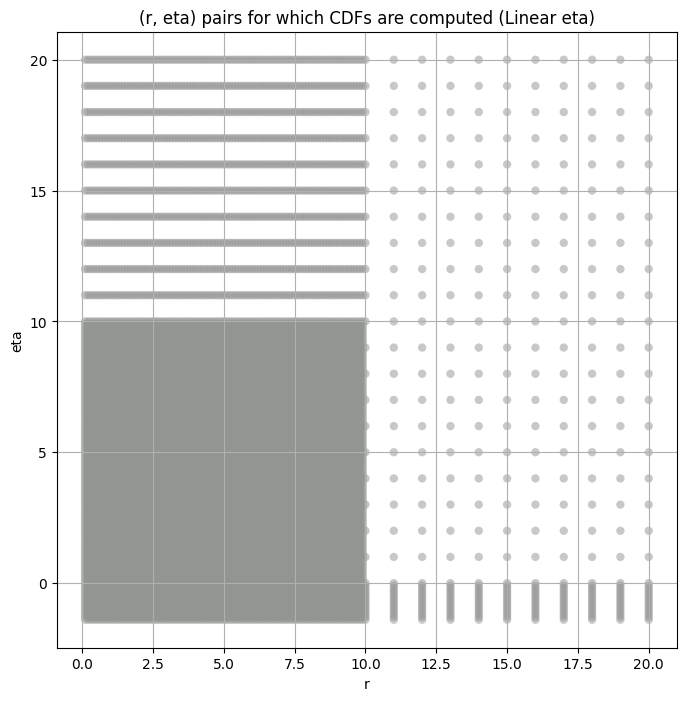

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.613543e+14  3.207987e+14  4.061076e+14   9.142671    6.224052   
5     7.557797e+14  6.677158e+14  8.492265e+14  19.873396   16.942110   
8     1.808529e+14  1.576540e+14  2.063592e+14  25.475584   19.418336   
11    1.057992e+13  9.763951e+12  1.160880e+13   9.404128    3.364547   
14    1.595975e+14  1.321700e+14  1.918671e+14  50.641156   31.101517   
17    3.993602e+14  3.720889e+14  4.289985e+14   5.592850    3.742511   
20    1.263410e+14  1.167919e+14  1.372403e+14   7.696341    4.559319   
23    1.395855e+13  1.306407e+13  1.500763e+13   5.143167    2.566483   
26    3.500124e+12  3.256700e+12  3.775107e+12   6.279109    3.885506   
30    4.321000e+10  3.903768e+10  4.820444e+10  14.699235    8.259990   

      kurt_upper  total_samples  
band                             
2      11.805546         2688.0  
5      22.943187         8064.0  
8      32.402627        22848.0  
11     22.641050        63168.0  
14     83.565282       174720.0  
17      9.274131       485184.0  
20     17.831333      1346688.0  
23     14.589871      3740352.0  
26     13.782796     10379712.0  
30     36.812461      7803264.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     3.613543e+14   3.613543e+14    2.688531e+14    2.338645e+14   
5     7.557797e+14   7.557797e+14    6.165701e+14    5.345902e+14   
8     1.808529e+14   1.808529e+14    1.609053e+14    1.490665e+14   
11    1.057992e+13   1.057992e+13    1.008492e+13    9.866310e+12   
14    1.595975e+14   1.595975e+14    1.427648e+14    1.337846e+14   
17    3.993602e+14   3.993602e+14    3.876738e+14    3.808234e+14   
20    1.263410e+14   1.263410e+14    1.218070e+14    1.192809e+14   
23    1.395855e+13   1.395855e+13    1.352924e+13    1.330821e+13   
26    3.500124e+12   3.500124e+12    3.389741e+12    3.325378e+12   
30    4.321000e+10   4.321000e+10    4.100769e+10    3.983254e+10   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       2.120994e+14     1.954457e+14     1.709032e+14     1.525892e+14   
5       4.749999e+14     4.280050e+14     3.553952e+14     3.037761e+14   
8       1.400873e+14     1.328004e+14     1.205701e+14     1.104636e+14   
11      9.693349e+12     9.552586e+12     9.318537e+12     9.118827e+12   
14      1.270507e+14     1.213694e+14     1.120101e+14     1.043956e+14   
17      3.752391e+14     3.703564e+14     3.618638e+14     3.545308e+14   
20      1.172553e+14     1.155058e+14     1.125088e+14     1.099618e+14   
23      1.313002e+13     1.297624e+13     1.271283e+13     1.248748e+13   
26      3.272906e+12     3.227132e+12     3.148337e+12     3.080861e+12   
30      3.889884e+10     3.810075e+10     3.675053e+10     3.561317e+10   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        1.380556e+14     1.255851e+14     1.145376e+14     8.915567e+13  
5        2.654806e+14     2.349302e+14     2.096347e+14     1.571567e+14  
8        1.018408e+14     9.430772e+13     8.788485e+13     7.294559e+13  
11       8.946308e+12     8.799475e+12     8.668031e+12     8.336914e+12  
14       9.804682e+13     9.254619e+13     8.765793e+13     7.576743e+13  
17       3.479850e+14     3.419935e+14     3.364635e+14     3.218413e+14  
20       1.077006e+14     1.056599e+14     1.037860e+14     9.888800e+13  
23       1.228758e+13     1.210625e+13     1.193888e+13     1.150020e+13  
26       3.021167e+12     2.967213e+12     2.917732e+12     2.788682e+12  
30       3.461855e+10     3.373159e+10     3.292765e+10     3.086763e+10

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01397607043860627 361354271985990.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.008432937314127253 268853096264367.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.013826037333276475 233864486963642.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.020209101570285104 212099433584598.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.025779203636469128 195445728381133.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.03456855171199491 170903238137615.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0414161233348512 152589161411626.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.051309899771339484 138055614298435.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.06213746994813241 125585051704101.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.07266733067678322 114537569985541.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.10097688826907744 89155667637519.3
Number of samples: 5376, Without approximation : 2688.0


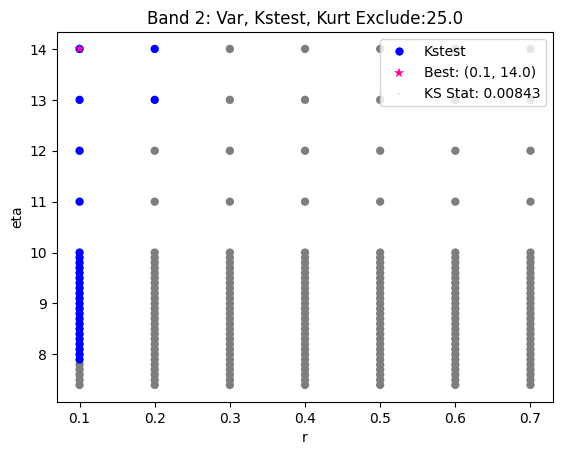

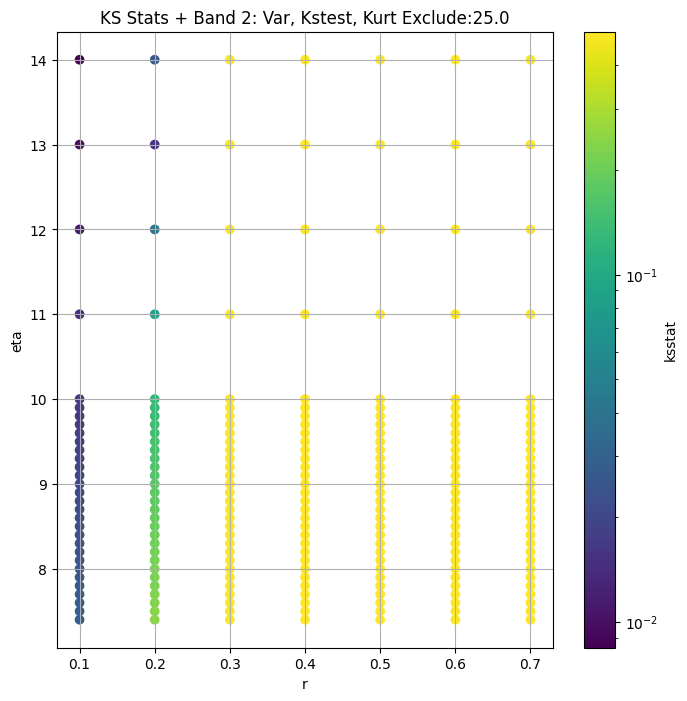

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.028918802686180634 755779683027149.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.024937122145616636 616570131879108.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.021131422752495577 534590216692255.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.01957013125420881 474999904045859.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.016785050642652788 428004984551575.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.015471354366955375 355395219067431.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.018548481247681048 303776070457988.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.020956547279373787 265480586432378.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.023174790879479268 234930218355570.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.025091143400464144 209634660380106.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.033418461773215453 157156743623764.53
Number of samples: 16128, Without approximation : 8064.0


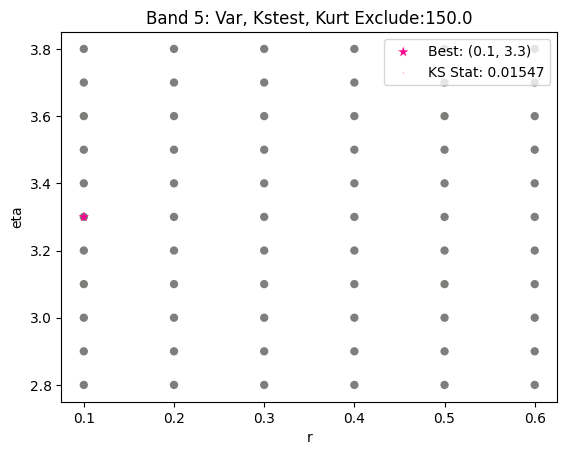

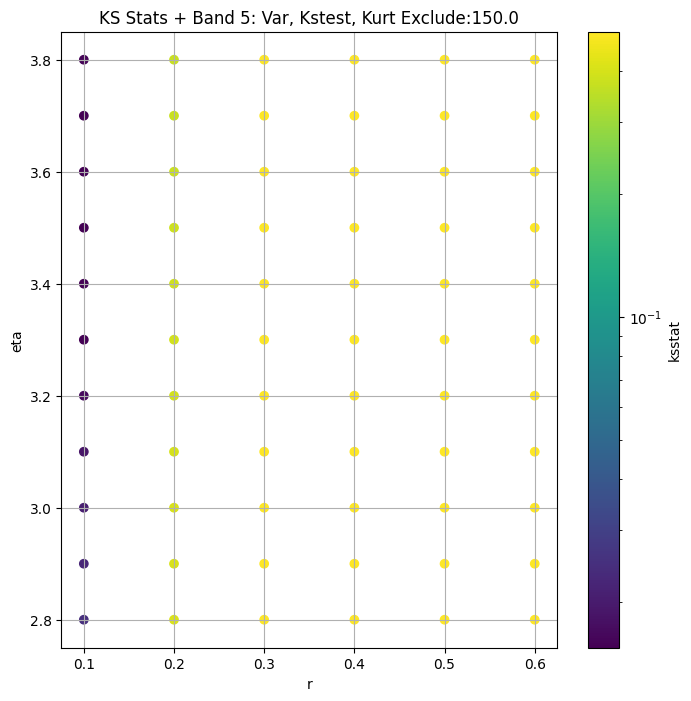

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.019410175531093147 180852878610569.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.019410175531093147 160905267286865.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.019410175531093147 149066526422583.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.019410175531093147 140087317493554.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.019410175531093147 132800424337029.77


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.019410175531093147 120570108109373.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.017935577844602757 110463573425386.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.015668808353205194 101840752021248.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.013729507379348749 94307719052134.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.011988097552344534 87884854809281.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.014224726535581909 72945591558767.55
Number of samples: 45696, Without approximation : 22848.0


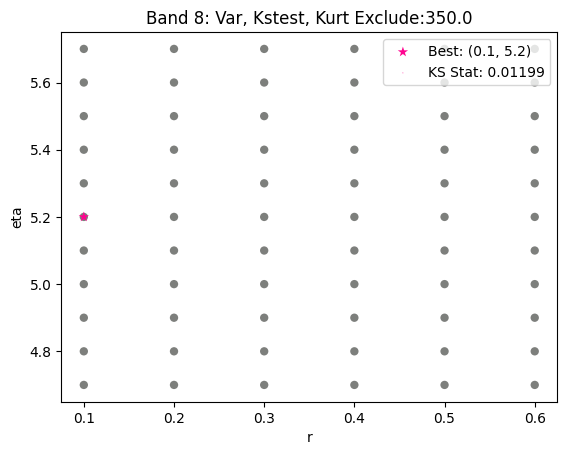

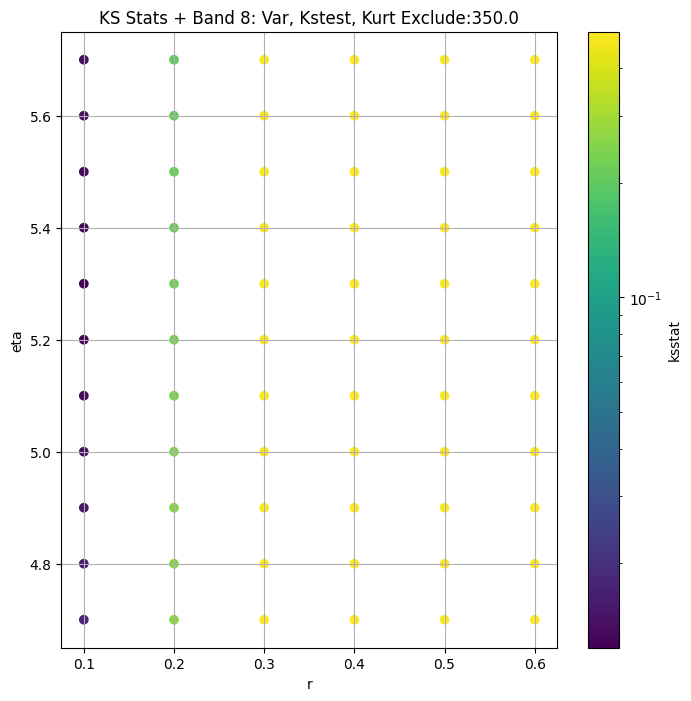

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.006818706065651159 10579923578931.871


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.005900796763240623 10084917422776.348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.004848134890203304 9866310222938.664


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.003951800525438198 9693348991052.092


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.003224488478285159 9552586189137.373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0025767399610441277 9318537242809.846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.002974040705720629 9118827316068.979


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.0033940526701742 8946307921571.047


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.003751804494501915 8799475260696.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.004269075982771828 8668030780059.835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.0059570268278831134 8336914320320.985
Number of samples: 100000, Without approximation : 63168.0


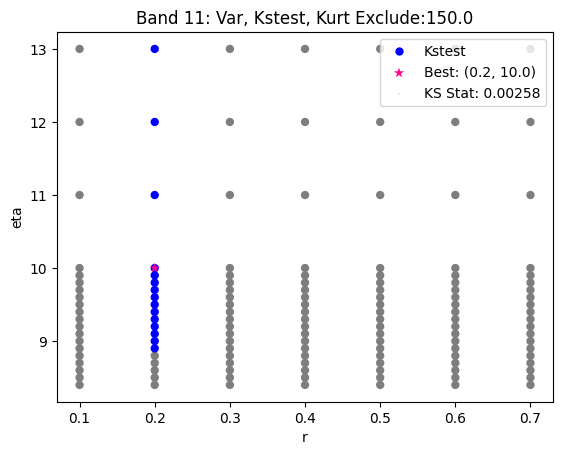

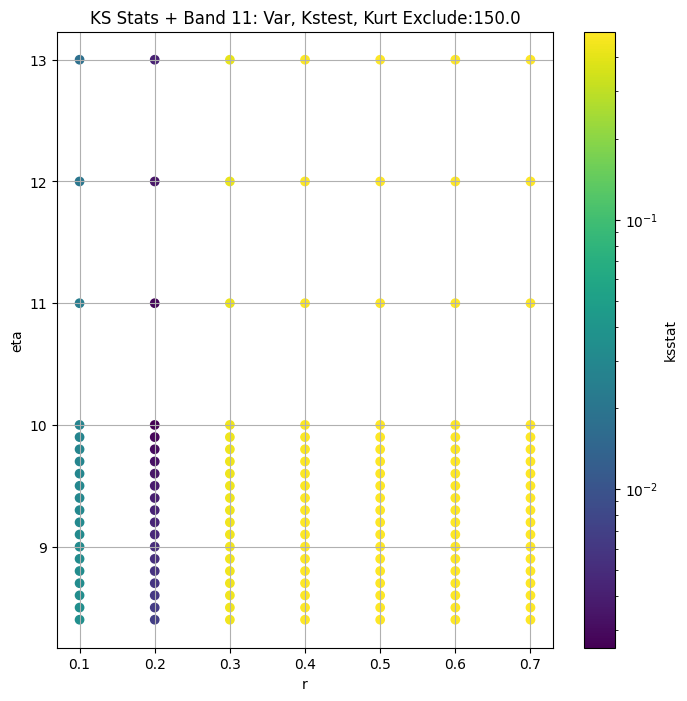

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.035909945761486706 159597475678128.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.03455149464139129 142764826087397.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.031107532423542195 133784562952098.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.03311216244969062 127050706232528.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.034900905377871494 121369363904946.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.030213450531577757 112010064305586.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.03044668986436455 104395589737310.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.031049328117686903 98046824735282.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.0276056572453659 92546194542082.45


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.02805353011356021 87657925511850.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.025456757323077173 75767425027172.05
Number of samples: 100000, Without approximation : 174720.0


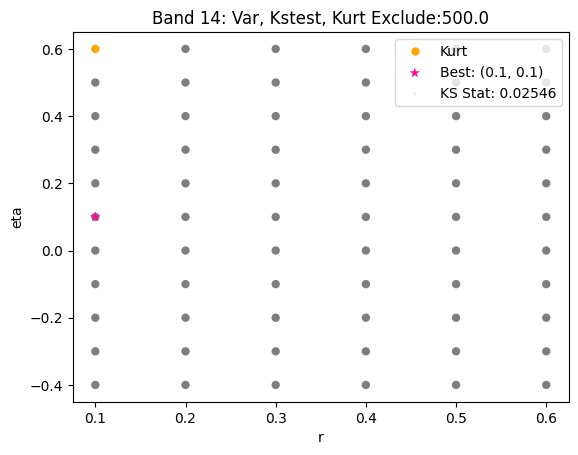

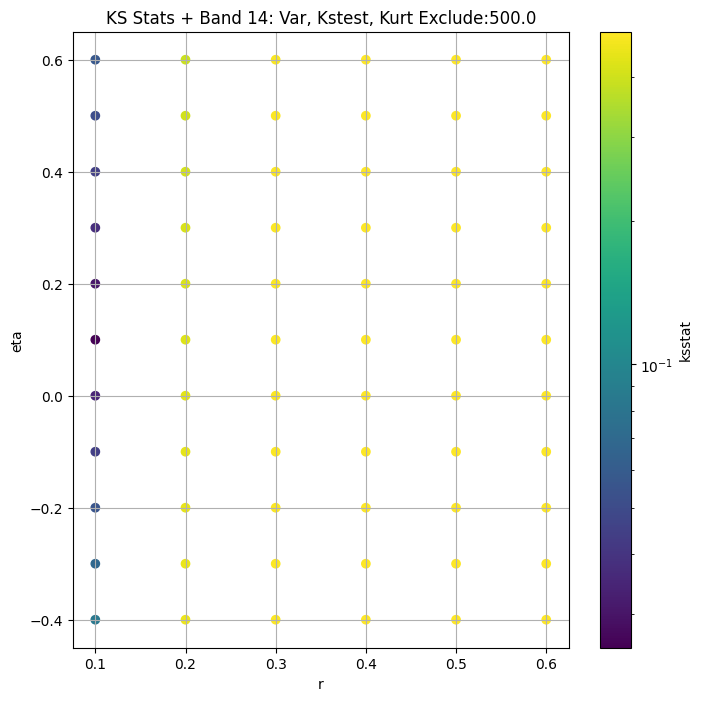

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.01240894458214331 399360220538642.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.013091992494703053 387673769195258.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.013318017627054451 380823417311189.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.013823719826623115 375239126333917.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.013951688406734775 370356375776268.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.01437788766883516 361863756759289.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.01502714281884572 354530847165163.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.015597326558484531 347984982510611.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.015962124309749193 341993469005243.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.016312062345240852 336463511246617.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.017667533216471576 321841261685253.7
Number of samples: 100000, Without approximation : 485184.0


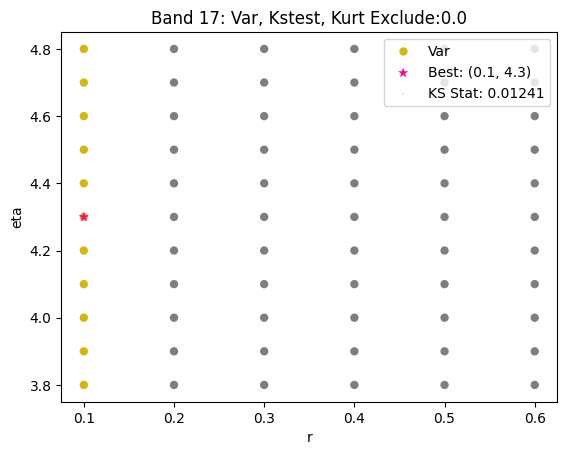

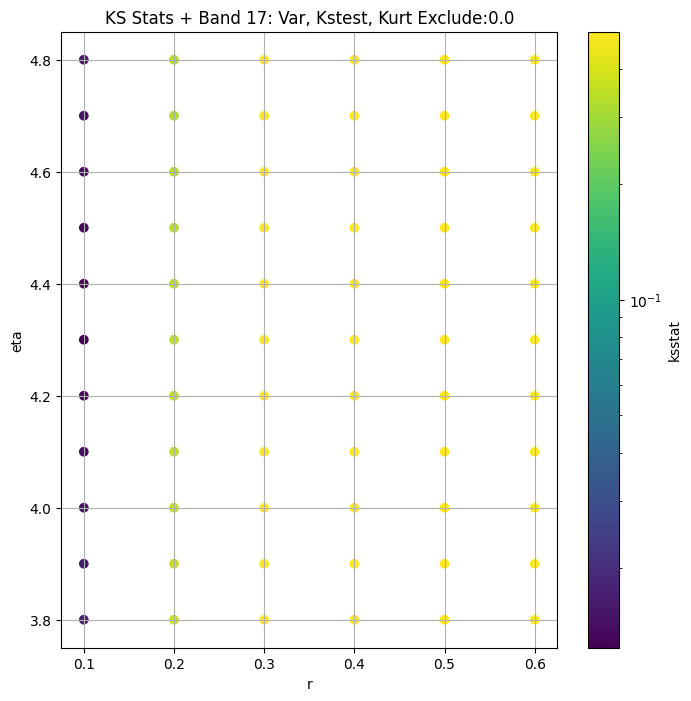

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0018234783678433564 126341034973569.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0015407837901349128 121807015035378.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0022703348050337954 119280861668825.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0028585857475841026 117255263223580.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.003402816325267056 115505826342600.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.004360452911037267 112508833767575.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.0052266848915365725 109961785327124.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.00604995799367157 107700594356897.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.006833820035143774 105659897358784.58


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.007581619200808298 103785991003525.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.009692275365147038 98887998133286.56
Number of samples: 100000, Without approximation : 1346688.0


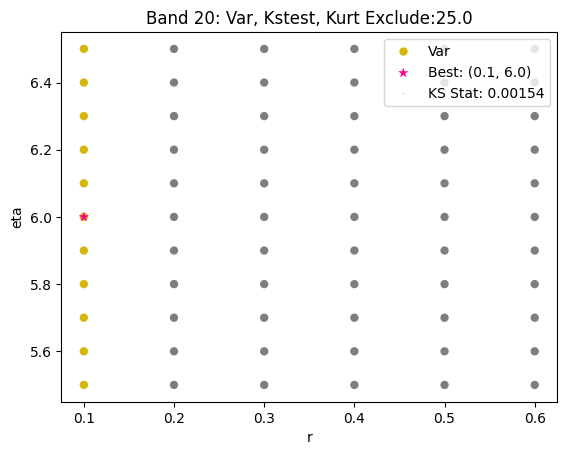

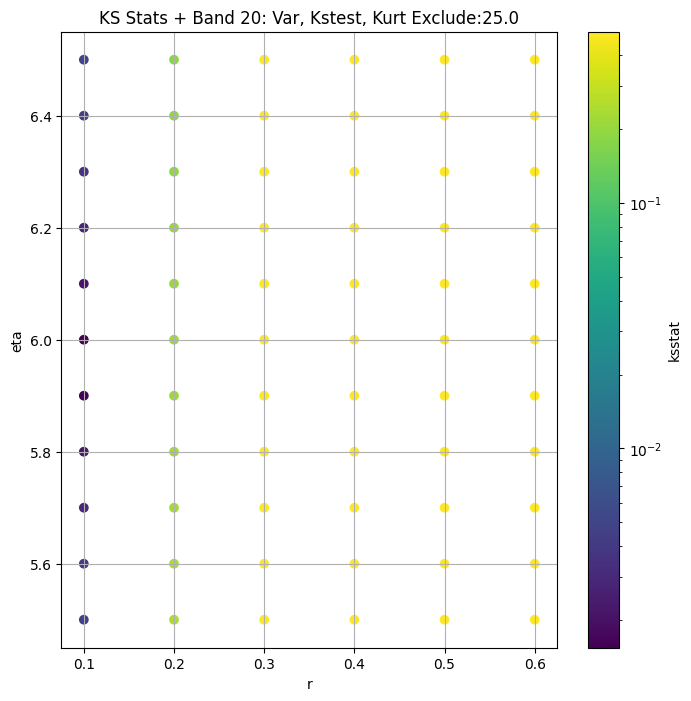

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0019062528610626073 13958546446719.416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0008845650919526715 13529236195760.729


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0010151903497696482 13308211083806.738


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.001360751766198768 13130019223167.055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0019469239639540309 12976236041422.807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.002715646937455383 12712832148529.314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0035949436241463073 12487476909397.678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004455997790246427 12287577004854.324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005272353769738794 12106253541969.146


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006048826913091519 11938879770531.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.008214545564737795 11500201163511.15
Number of samples: 100000, Without approximation : 3740352.0


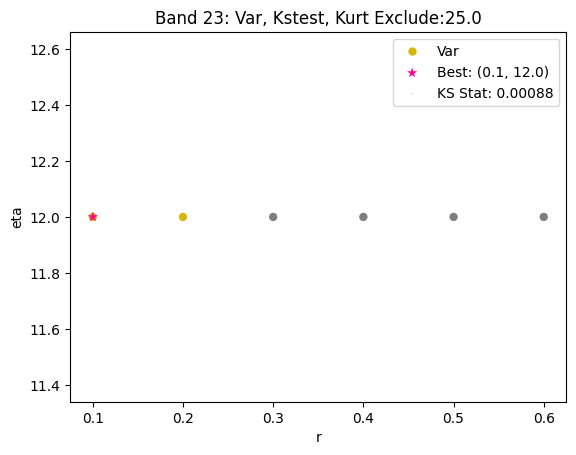

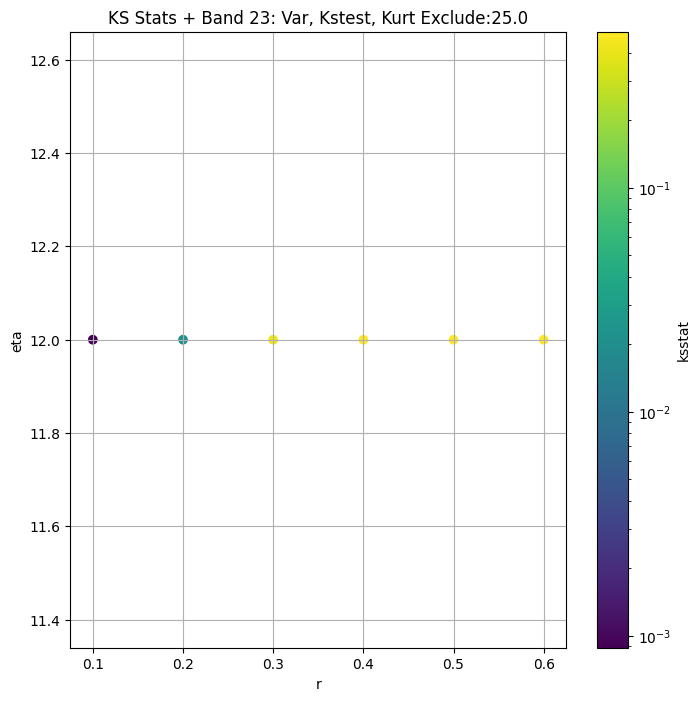

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0019711204709258467 3500124268000.5537


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0012054034654216395 3389740885383.7754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0014577395779951097 3325377835884.0044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0019150687375527747 3272905524545.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.0024271136075819134 3227131670563.839


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.003406921351827047 3148337274539.188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004299184556891676 3080861438000.5283


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.004892857839554635 3021166771154.6226


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.005638398131916345 2967213198018.4346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.006393618721859576 2917731975549.3716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.008556180141769683 2788682440534.984
Number of samples: 100000, Without approximation : 10379712.0


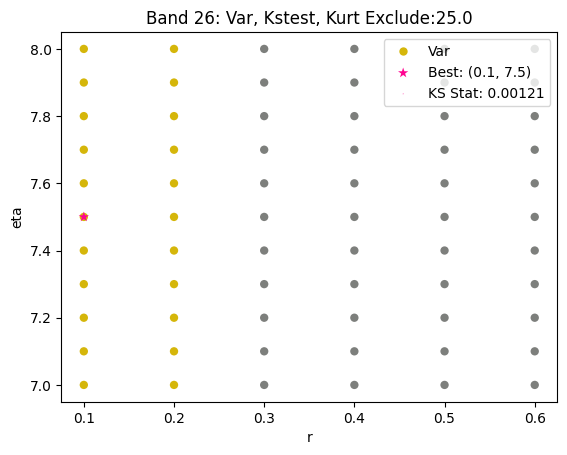

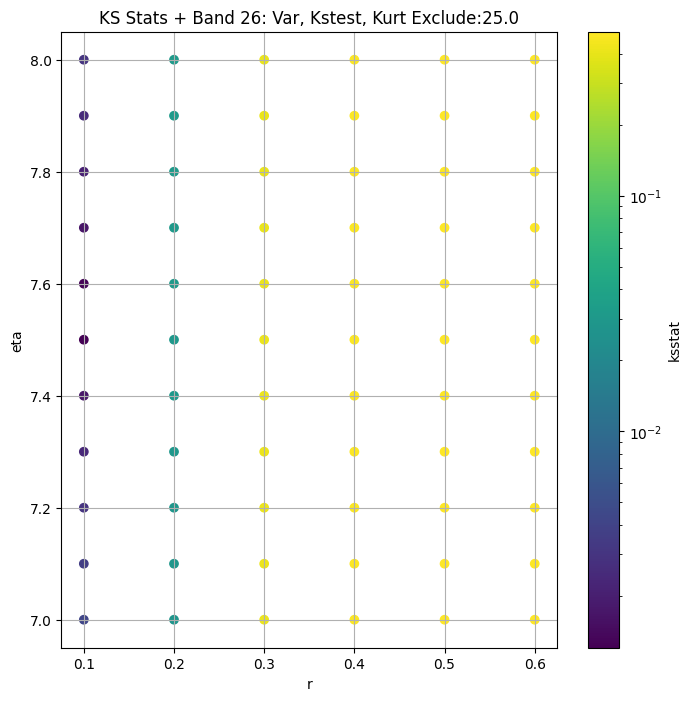

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.005793880862205891 43210000253.40086


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.004588226505484572 41007693515.95364


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.004574808021893695 39832538091.39033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.003916437688752716 38898838920.10301


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.003856908174824411 38100752397.65249


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.004826801379550067 36750530214.3811


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.005122881810666894 35613165261.314354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.0059692924946522195 34618554501.90304


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.006785573562892486 33731594437.224648


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.007530250314006334 32927647451.099422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.009660501067047716 30867625207.569263
Number of samples: 100000, Without approximation : 7803264.0


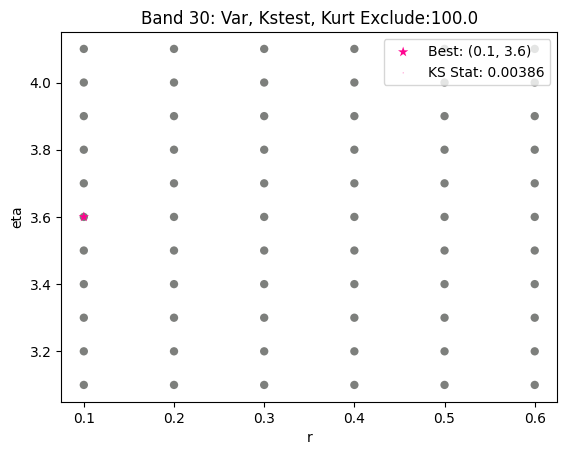

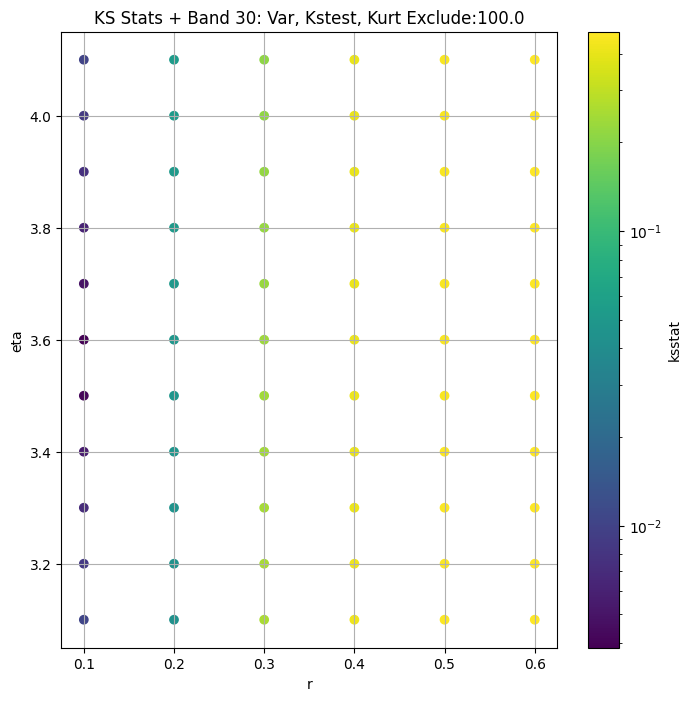

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.613543e+14  3.207987e+14  4.061076e+14   9.142671    6.224052   
5     7.557797e+14  6.677158e+14  8.492265e+14  19.873396   16.942110   
8     1.808529e+14  1.576540e+14  2.063592e+14  25.475584   19.418336   
11    1.057992e+13  9.763951e+12  1.160880e+13   9.404128    3.364547   
14    1.595975e+14  1.321700e+14  1.918671e+14  50.641156   31.101517   
17    3.993602e+14  3.720889e+14  4.289985e+14   5.592850    3.742511   
20    1.263410e+14  1.167919e+14  1.372403e+14   7.696341    4.559319   
23    1.395855e+13  1.306407e+13  1.500763e+13   5.143167    2.566483   
26    3.500124e+12  3.256700e+12  3.775107e+12   6.279109    3.885506   
30    4.321000e+10  3.903768e+10  4.820444e+10  14.699235    8.259990   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      11.805546         2688.0             0.008433        0.1         14.0   
5      22.943187         8064.0             0.015471        0.1          3.3   
8      32.402627        22848.0             0.011988        0.1          5.2   
11     22.641050        63168.0             0.002577        0.2         10.0   
14     83.565282       174720.0             0.025457        0.1          0.1   
17      9.274131       485184.0             0.012409        0.1          4.3   
20     17.831333      1346688.0             0.001541        0.1          6.0   
23     14.589871      3740352.0             0.000885        0.1         12.0   
26     13.782796     10379712.0             0.001205        0.1          7.5   
30     36.812461      7803264.0             0.003857        0.1          3.6   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.527043e-08                    25.0        2.688531e+14   
5      2.267961e-03                   150.0        3.553952e+14   
8      2.537248e-05                   350.0        8.788485e+13   
11     1.251344e+04                   150.0        9.318537e+12   
14     6.387582e+00                   500.0        7.576743e+13   
17     4.437715e-04                     0.0        3.993602e+14   
20     1.215735e-05                    25.0        1.218070e+14   
23     4.857940e-09                    25.0        1.352924e+13   
26     5.995924e-08                    25.0        3.389741e+12   
30     1.392623e-07                   100.0        3.810075e+10   

      kstest_stat_cutoff_0.05  
band                           
2                    0.026132  
5                    0.015103  
8                    0.008977  
11                   0.005401  
14                   0.003248  
17                   0.001949  
20                   0.001170  
23                   0.000702  
26                   0.000422  
30                   0.000486

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 100 = 125, ksstat: 0.030589585271514008, var: 182347751661981.22


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 75 = 100, ksstat: 0.026024765342443468, var: 195445728381133.47


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 50 = 75, ksstat: 0.020289178232783422, var: 212099433584598.94


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 25 = 50, ksstat: 0.013773538629867965, var: 233864486963642.1


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 0 = 25, ksstat: 0.008432937314127253, var: 268853096264367.44


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + -25 = 0, ksstat: 0.03914174346407695, var: 361354271985990.2
Number of samples: 5376, Without approximation : 2688.0


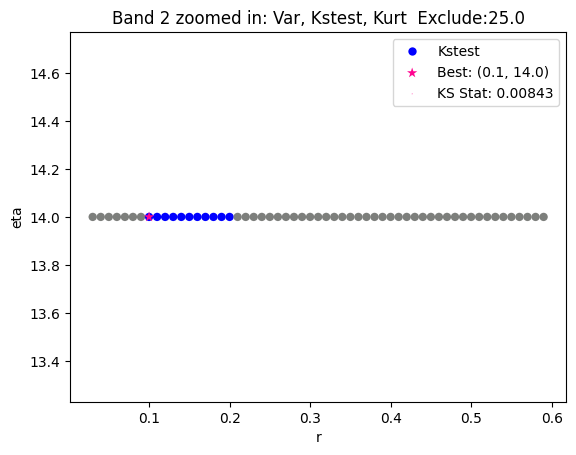

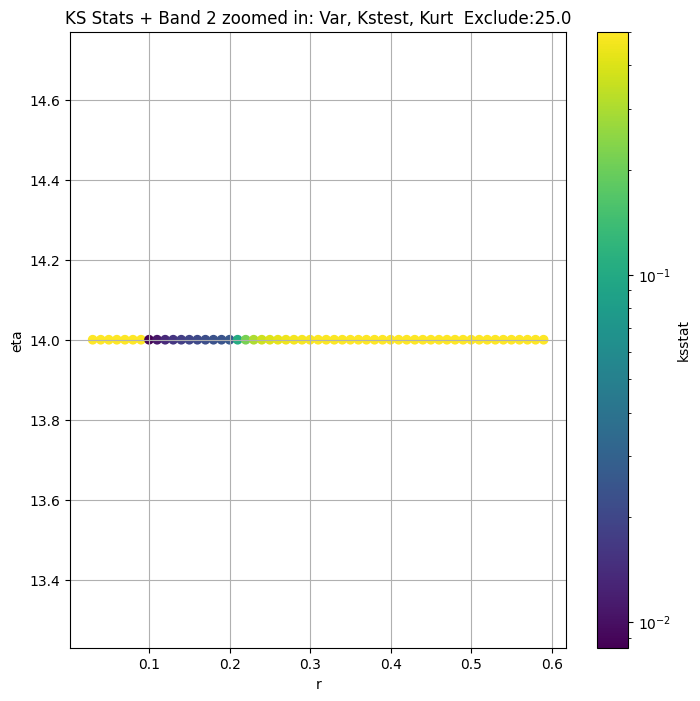

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 100 = 250, ksstat: 0.020934212705393574, var: 265480586432378.12


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 75 = 225, ksstat: 0.019793967613829216, var: 283383272592136.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 50 = 200, ksstat: 0.018515723120304584, var: 303776070457988.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 25 = 175, ksstat: 0.017059826990108058, var: 328016433415618.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 0 = 150, ksstat: 0.015442967996532553, var: 355395219067431.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + -25 = 125, ksstat: 0.014632848317230995, var: 388393054446422.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + -50 = 100, ksstat: 0.01615986989496565, var: 428004984551575.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + -75 = 75, ksstat: 0.01885780770615833, var: 474999904045859.56


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + -100 = 50, ksstat: 0.020570042220995455, var: 534590216692255.2
Number of samples: 16128, Without approximation : 8064.0


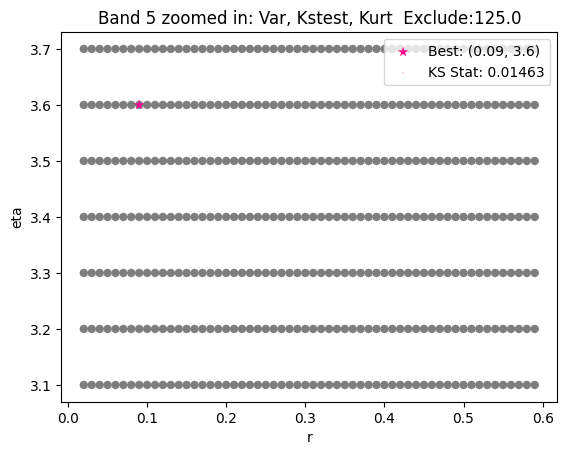

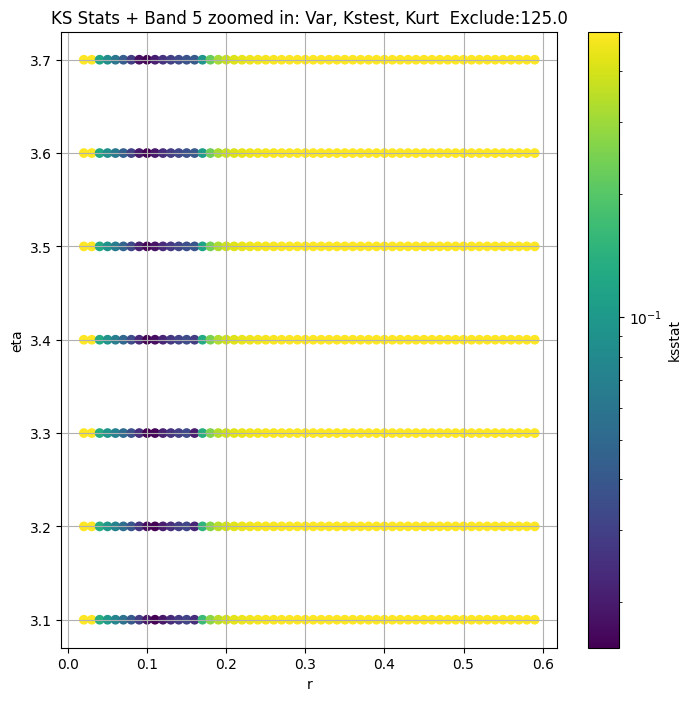

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.013380926093462309, var: 77272455282398.12


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.012955409658261443, var: 79700566505148.83


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.012515746723675392, var: 82270873140068.34


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.01201589338766429, var: 84999452400171.83


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.011988097552344534, var: 87884854809281.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.01270007254716675, var: 90990141093676.69


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.013536451654241624, var: 94307719052134.42


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.014712131039825715, var: 97935963338206.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.01539884562356647, var: 101840752021248.52
Number of samples: 45696, Without approximation : 22848.0


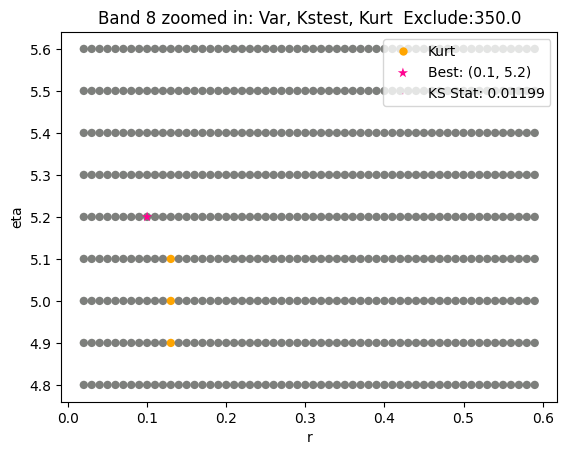

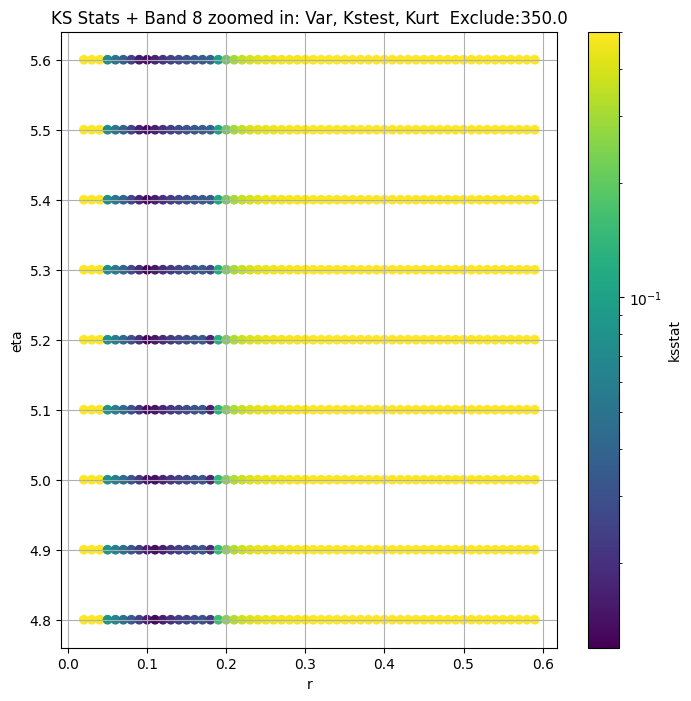

Band 11


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + 100 = 250, ksstat: 0.005449130234468469, var: 8946307921571.047


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + 75 = 225, ksstat: 0.004513659209586629, var: 9029126885694.338


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + 50 = 200, ksstat: 0.0035121782181263272, var: 9118827316068.979


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + 25 = 175, ksstat: 0.002762838996226703, var: 9215066706875.602


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + 0 = 150, ksstat: 0.0025767399610441277, var: 9318537242809.846


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + -25 = 125, ksstat: 0.002720852809983132, var: 9429858239408.037


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + -50 = 100, ksstat: 0.003190746252798471, var: 9552586189137.373


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + -75 = 75, ksstat: 0.0039059348166757824, var: 9693348991052.092


  0%|          | 0/344 [00:00<?, ?it/s]

Finding Minimum after computing 344 CDFs
band 11, 150.0 + -100 = 50, ksstat: 0.00473488247738596, var: 9866310222938.664
Number of samples: 100000, Without approximation : 63168.0


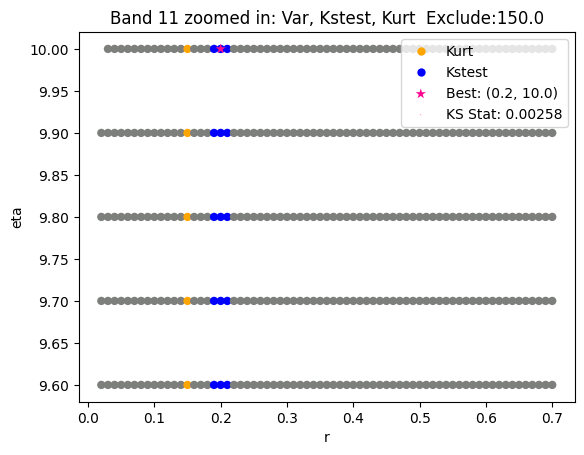

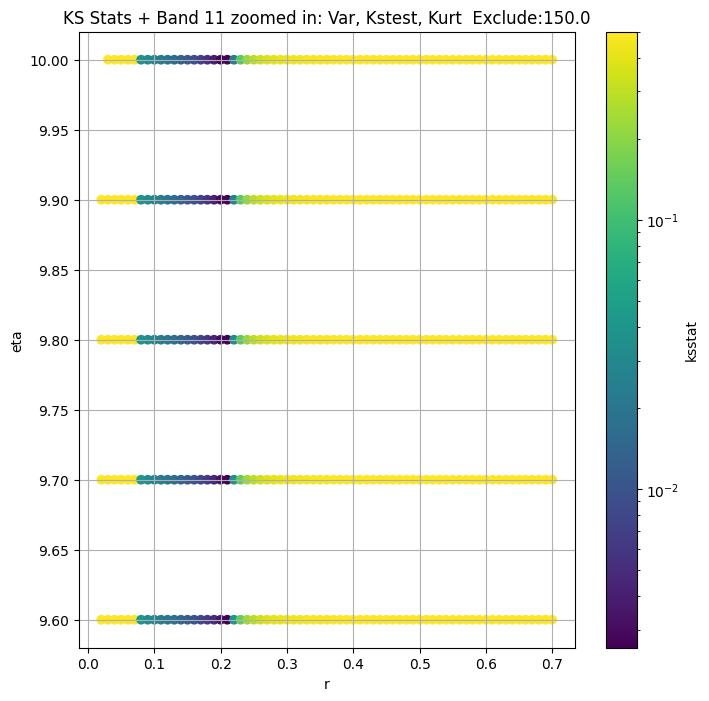

Band 14


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 100 = 600, ksstat: 0.02379507485319665, var: 69454804083928.43


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 75 = 575, ksstat: 0.024952103168878748, var: 70946316938842.75


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 50 = 550, ksstat: 0.026276315250797433, var: 72492534701948.08


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 25 = 525, ksstat: 0.02583018041041607, var: 74098146640341.81


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + 0 = 500, ksstat: 0.02488476329877065, var: 75767425027172.05


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + -25 = 475, ksstat: 0.02403437219561655, var: 77506698497933.05


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + -50 = 450, ksstat: 0.02545221635153383, var: 79331160821730.06


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + -75 = 425, ksstat: 0.024818868701032337, var: 81249506558155.47


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 500.0 + -100 = 400, ksstat: 0.02453046361077671, var: 83273582917306.52
Number of samples: 100000, Without approximation : 174720.0


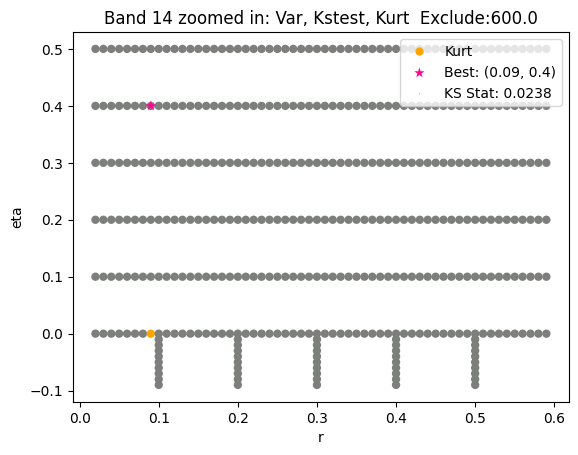

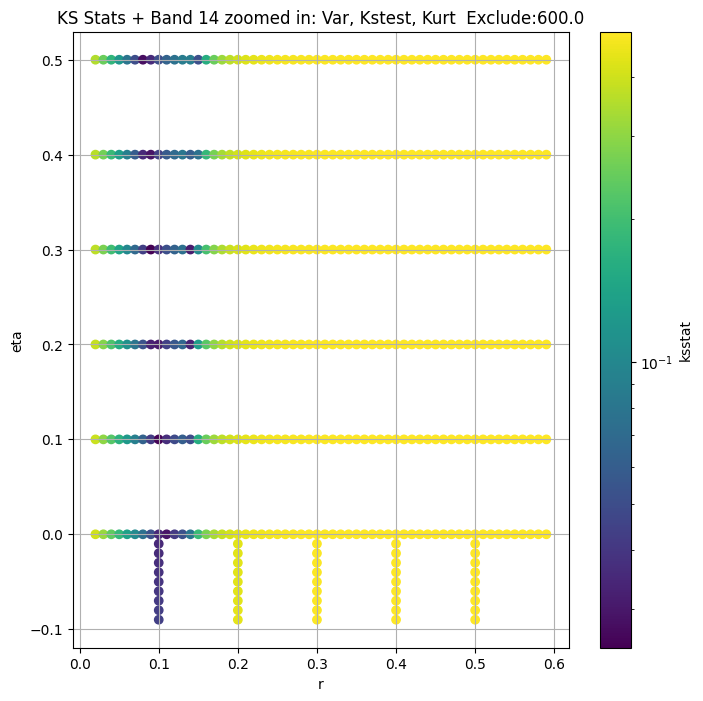

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.01390606805340422, var: 370356375776268.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.013743975636354877, var: 375239126333917.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.013269766612593256, var: 380823417311189.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.012818639874139448, var: 387673769195258.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.01240894458214331, var: 399360220538642.75
Number of samples: 100000, Without approximation : 485184.0


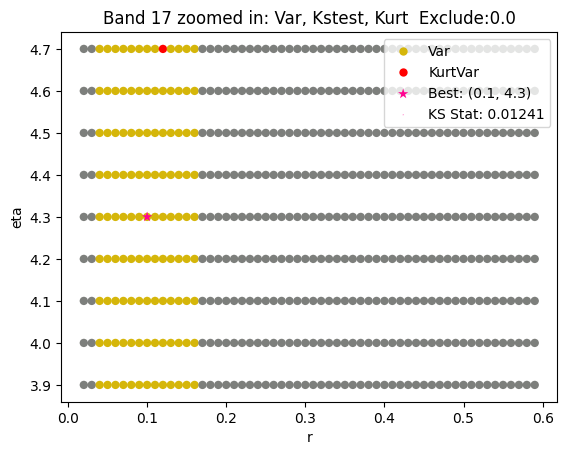

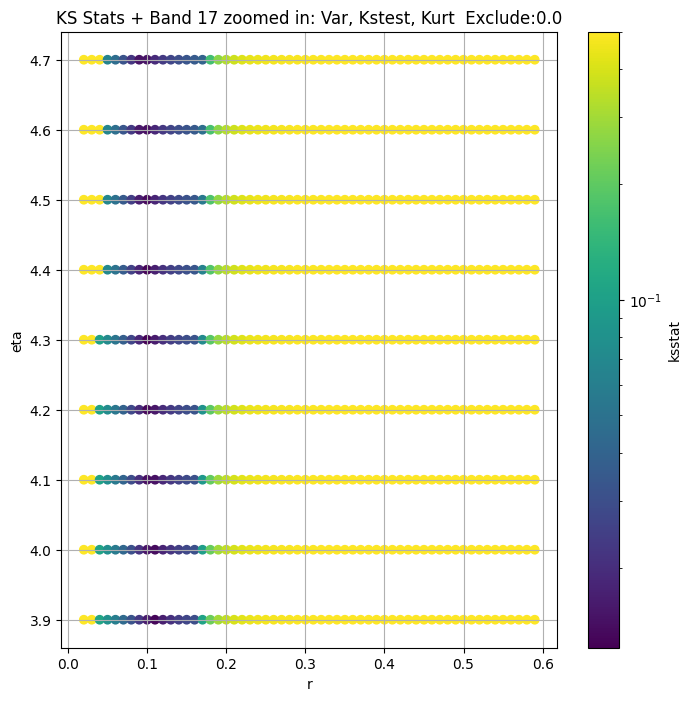

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.0038186428256671186, var: 113937360637514.56


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.0033617569748963898, var: 115505826342600.28


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.002817793120978969, var: 117255263223580.97


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.0022158585270314404, var: 119280861668825.19


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0015407837901349128, var: 121807015035378.28


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0016061912164883063, var: 126341034973569.19
Number of samples: 100000, Without approximation : 1346688.0


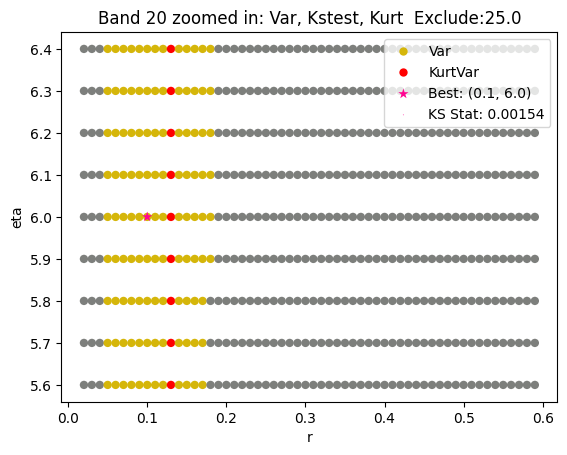

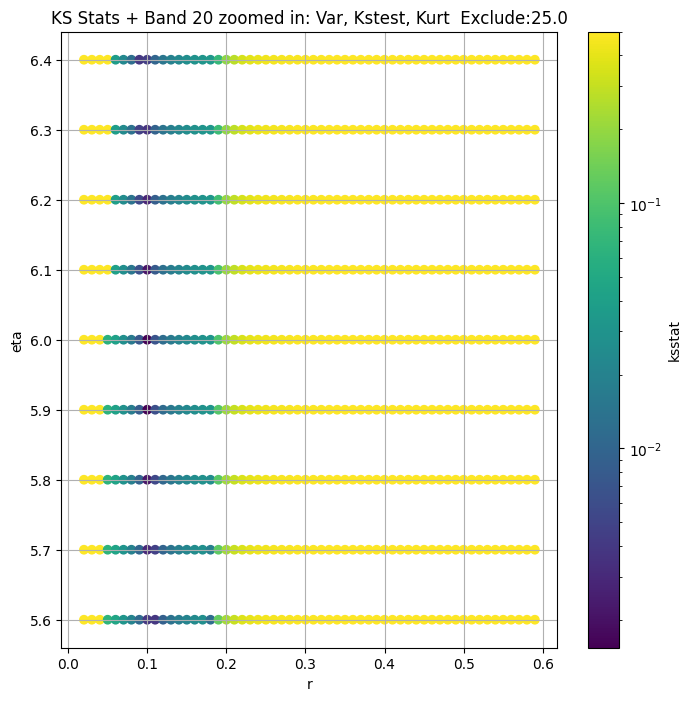

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.0024304836037058117, var: 12838697307612.963


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.0018681132550629823, var: 12976236041422.807


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0014217742616179294, var: 13130019223167.055


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.0015987232824915543, var: 13308211083806.738


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0008845650919526715, var: 13529236195760.729


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.002647508791728592, var: 13958546446719.416
Number of samples: 100000, Without approximation : 3740352.0


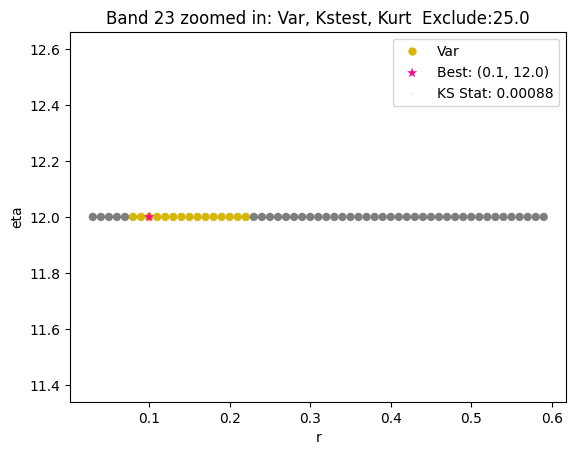

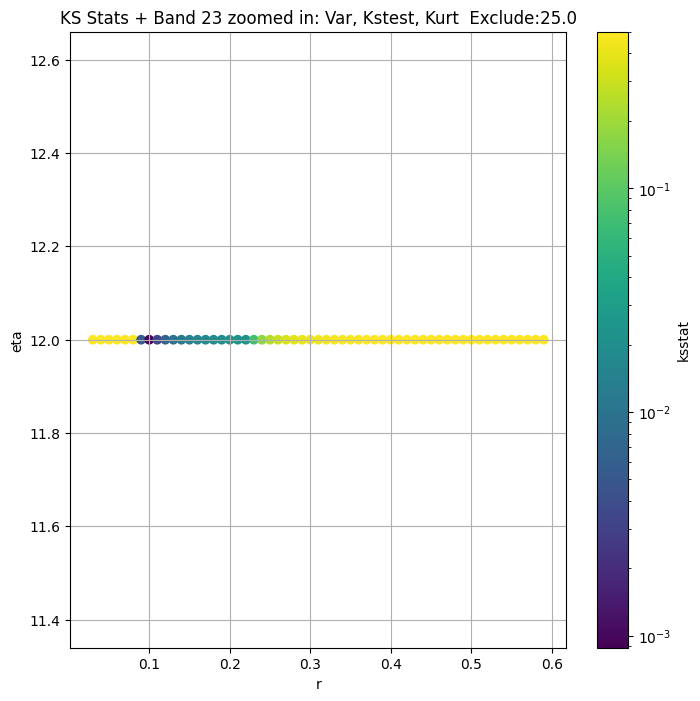

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 100 = 125, ksstat: 0.002895046390611899, var: 3186011234025.115


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 75 = 100, ksstat: 0.0023910983955292738, var: 3227131670563.839


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 50 = 75, ksstat: 0.0019123580175098298, var: 3272905524545.42


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 25 = 50, ksstat: 0.0014577395779951097, var: 3325377835884.0044


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 0 = 25, ksstat: 0.0012054034654216395, var: 3389740885383.7754


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + -25 = 0, ksstat: 0.002228555638508878, var: 3500124268000.5537
Number of samples: 100000, Without approximation : 10379712.0


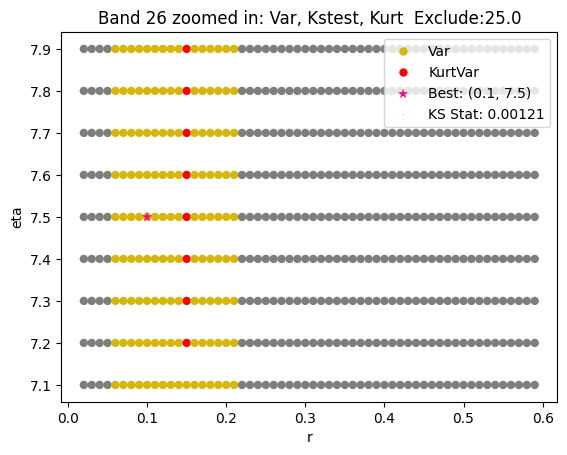

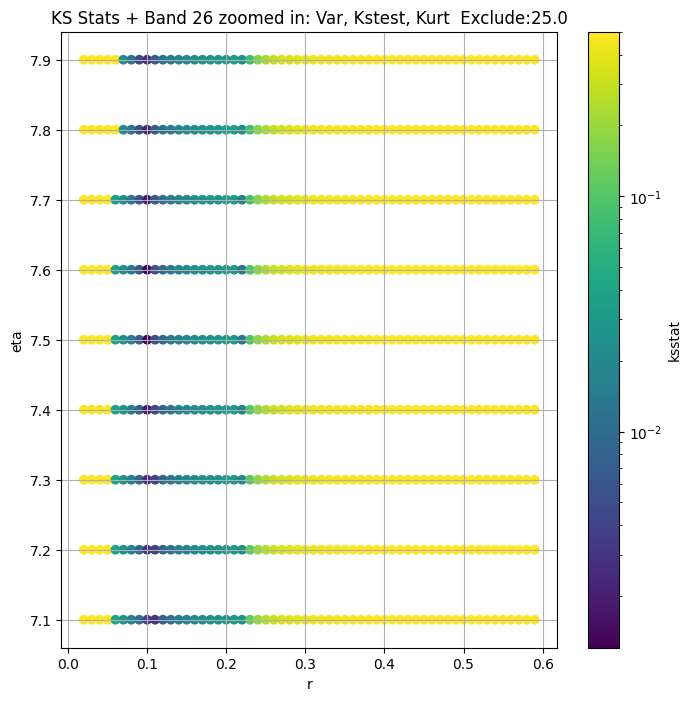

Band 30


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 100 = 200, ksstat: 0.005570044143453603, var: 35613165261.314354


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 75 = 175, ksstat: 0.005215490157904238, var: 36161096187.33757


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 50 = 150, ksstat: 0.004744203792641694, var: 36750530214.3811


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 25 = 125, ksstat: 0.0043129304502783974, var: 37392072872.455986


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + 0 = 100, ksstat: 0.003856908174824411, var: 38100752397.65249


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + -25 = 75, ksstat: 0.003916437688752716, var: 38898838920.10301


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + -50 = 50, ksstat: 0.0039577997859086556, var: 39832538091.39033


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + -75 = 25, ksstat: 0.004588226505484572, var: 41007693515.95364


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 30, 100.0 + -100 = 0, ksstat: 0.005239490294322913, var: 43210000253.40086
Number of samples: 100000, Without approximation : 7803264.0


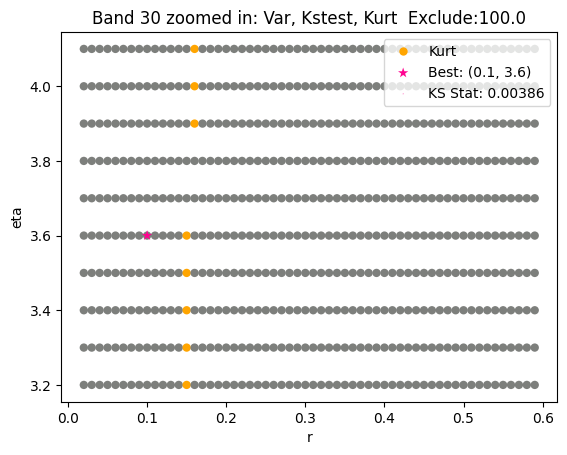

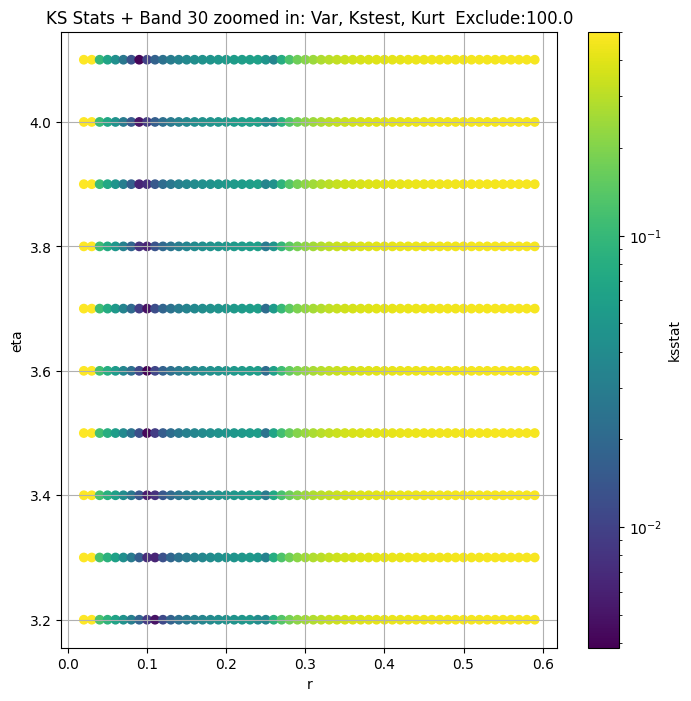

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.613543e+14  3.207987e+14  4.061076e+14   9.142671    6.224052   
5     7.557797e+14  6.677158e+14  8.492265e+14  19.873396   16.942110   
8     1.808529e+14  1.576540e+14  2.063592e+14  25.475584   19.418336   
11    1.057992e+13  9.763951e+12  1.160880e+13   9.404128    3.364547   
14    1.595975e+14  1.321700e+14  1.918671e+14  50.641156   31.101517   
17    3.993602e+14  3.720889e+14  4.289985e+14   5.592850    3.742511   
20    1.263410e+14  1.167919e+14  1.372403e+14   7.696341    4.559319   
23    1.395855e+13  1.306407e+13  1.500763e+13   5.143167    2.566483   
26    3.500124e+12  3.256700e+12  3.775107e+12   6.279109    3.885506   
30    4.321000e+10  3.903768e+10  4.820444e+10  14.699235    8.259990   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      11.805546         2688.0             0.008433        0.1         14.0   
5      22.943187         8064.0             0.015471        0.1          3.3   
8      32.402627        22848.0             0.011988        0.1          5.2   
11     22.641050        63168.0             0.002577        0.2         10.0   
14     83.565282       174720.0             0.025457        0.1          0.1   
17      9.274131       485184.0             0.012409        0.1          4.3   
20     17.831333      1346688.0             0.001541        0.1          6.0   
23     14.589871      3740352.0             0.000885        0.1         12.0   
26     13.782796     10379712.0             0.001205        0.1          7.5   
30     36.812461      7803264.0             0.003857        0.1          3.6   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.527043e-08                    25.0        2.688531e+14   
5      2.267961e-03                   150.0        3.883931e+14   
8      2.537248e-05                   350.0        8.788485e+13   
11     1.251344e+04                   150.0        9.318537e+12   
14     6.387582e+00                   500.0        6.945480e+13   
17     4.437715e-04                     0.0        3.993602e+14   
20     1.215735e-05                    25.0        1.218070e+14   
23     4.857940e-09                    25.0        1.352924e+13   
26     5.995924e-08                    25.0        3.389741e+12   
30     1.392623e-07                   100.0        3.810075e+10   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.026132          0.008433    0.10      14.0   
5                    0.015103          0.014633    0.09       3.6   
8                    0.008977          0.011988    0.10       5.2   
11                   0.005401          0.002577    0.20      10.0   
14                   0.003248          0.023795    0.09       0.4   
17                   0.001949          0.012409    0.10       4.3   
20                   0.001170          0.001541    0.10       6.0   
23                   0.000702          0.000885    0.10      12.0   
26                   0.000422          0.001205    0.10       7.5   
30                   0.000486          0.003857    0.10       3.6   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     2.527043e-08                 25.0        25833  
5     5.034482e-06                125.0         9072  
8     2.537248e-05                350.0        12852  
11    1.251344e+04                150.0       269820  
14    1.334717e-02                600.0         3274  
17    4.437715e-04                  0.0        11371  
20    1.215735e-05                 25.0       757512  
23    4.857940e-09                 25.0     

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

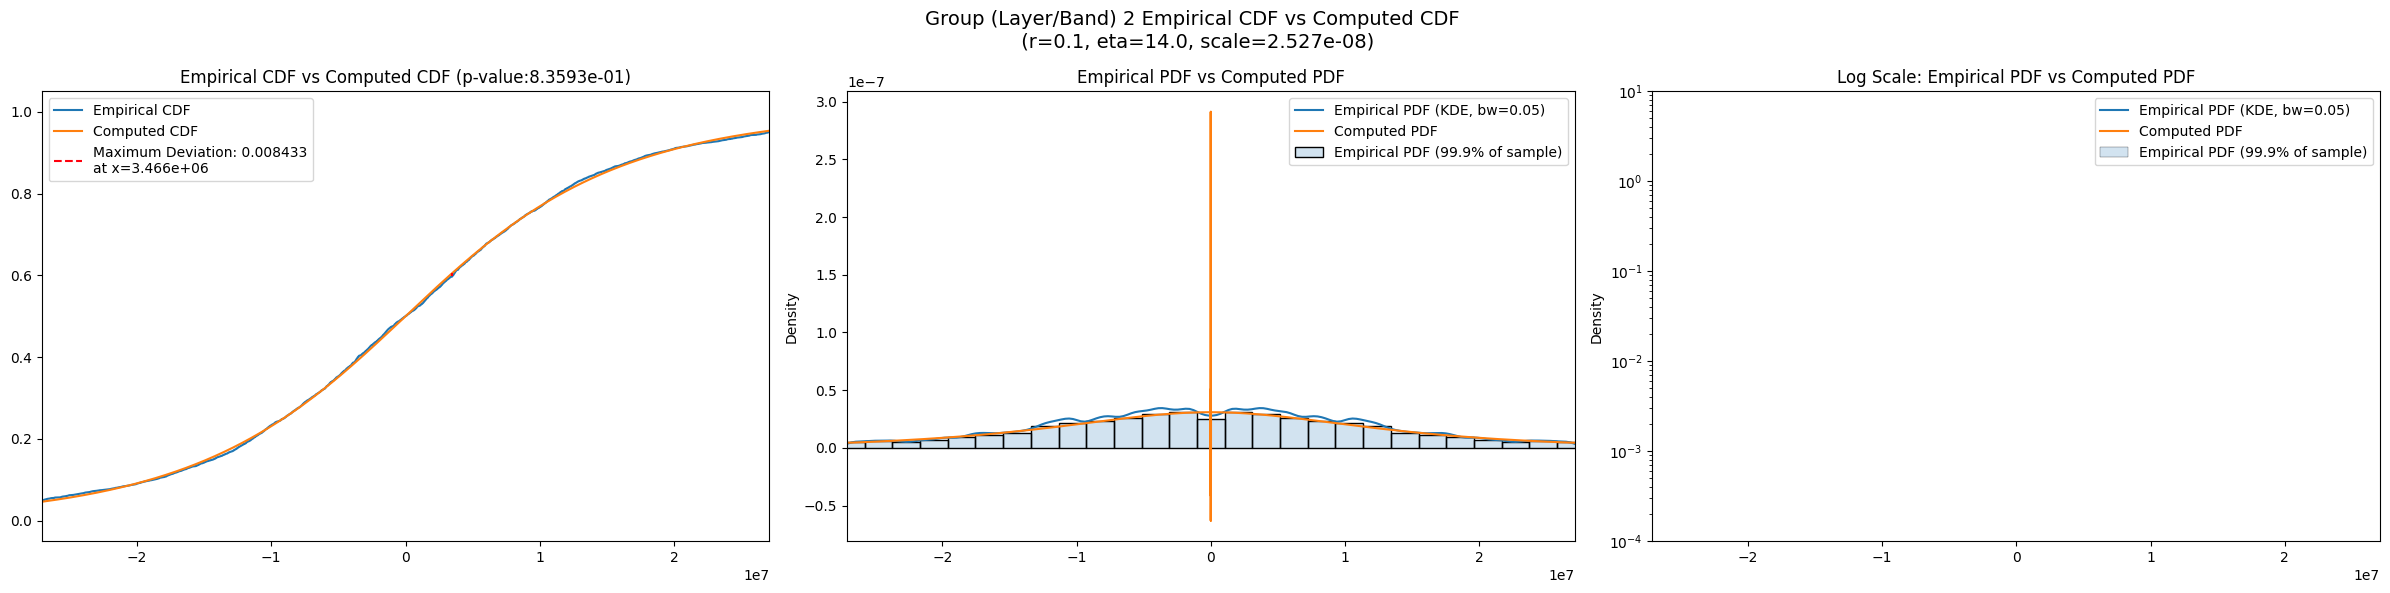

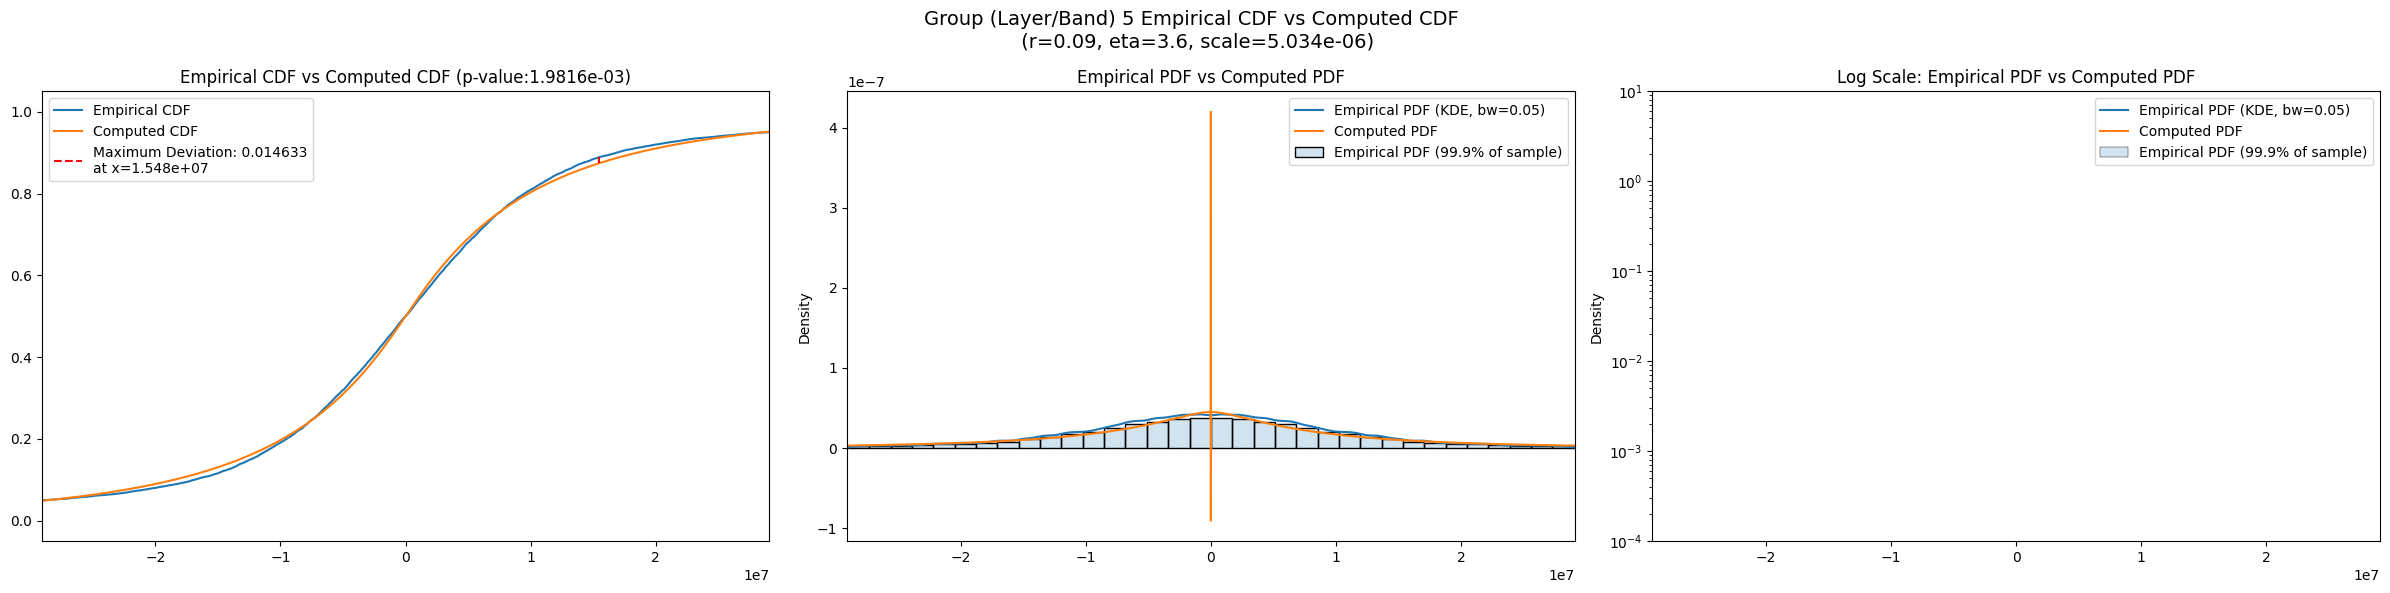

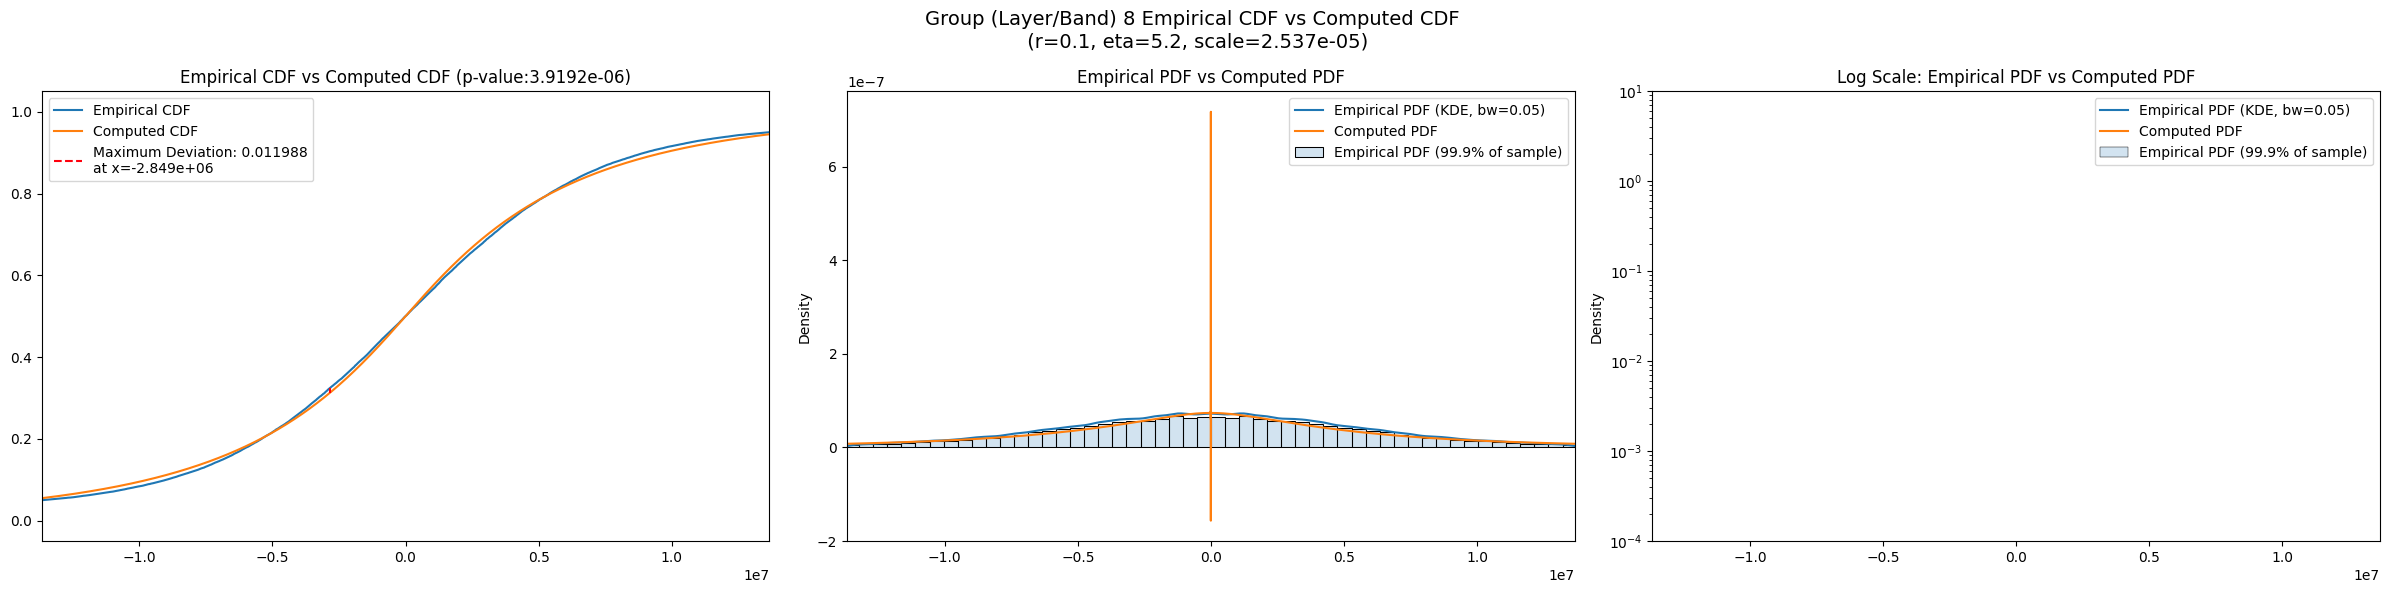

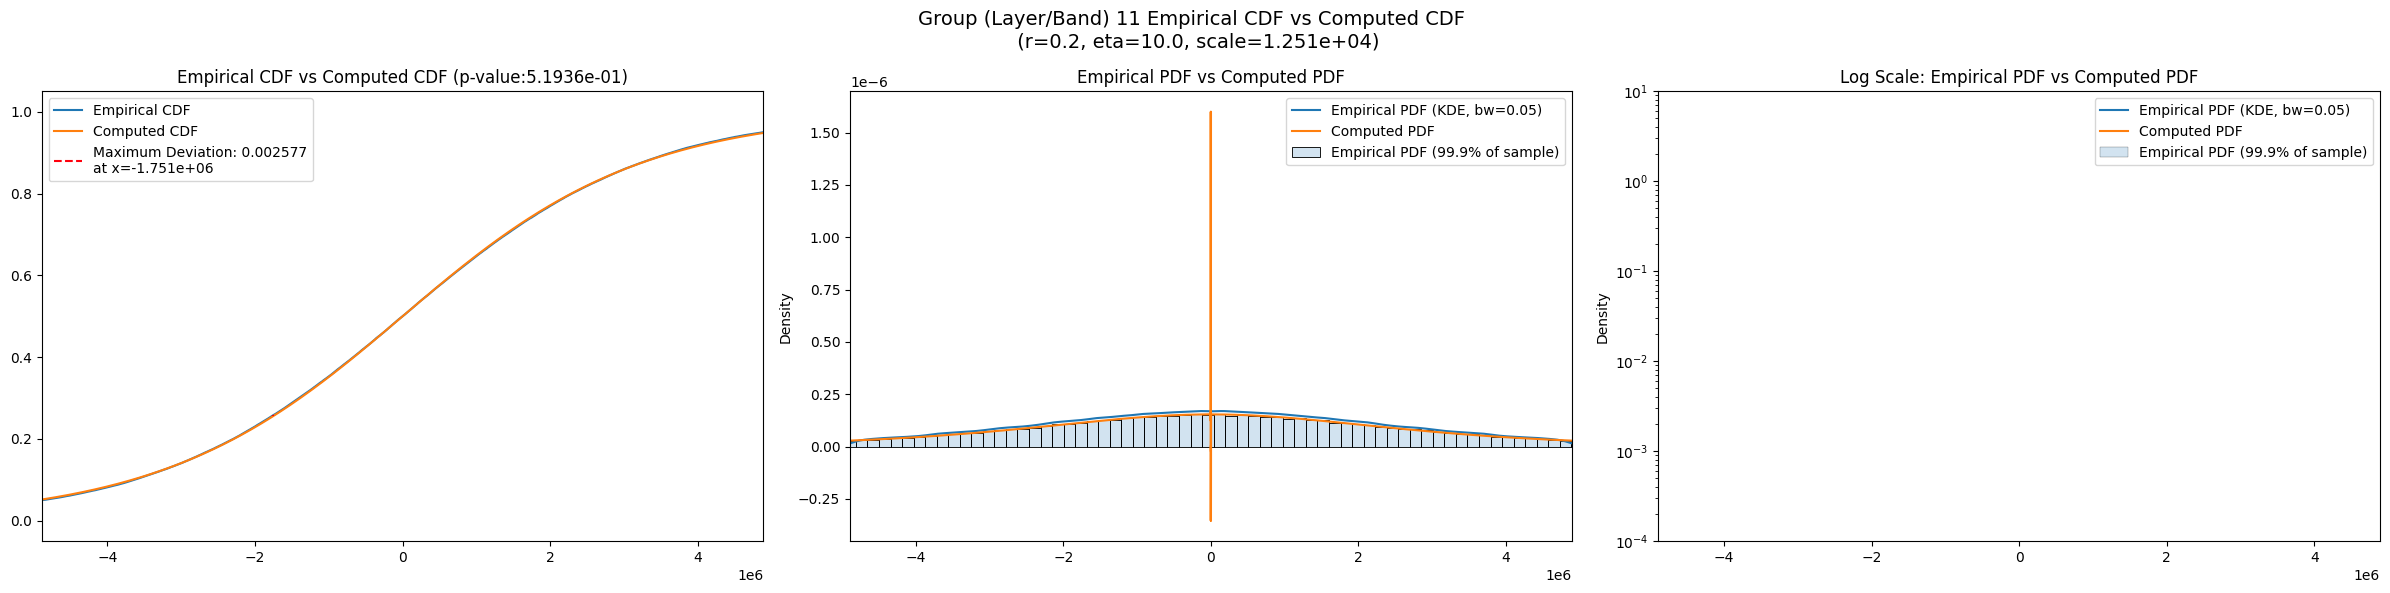

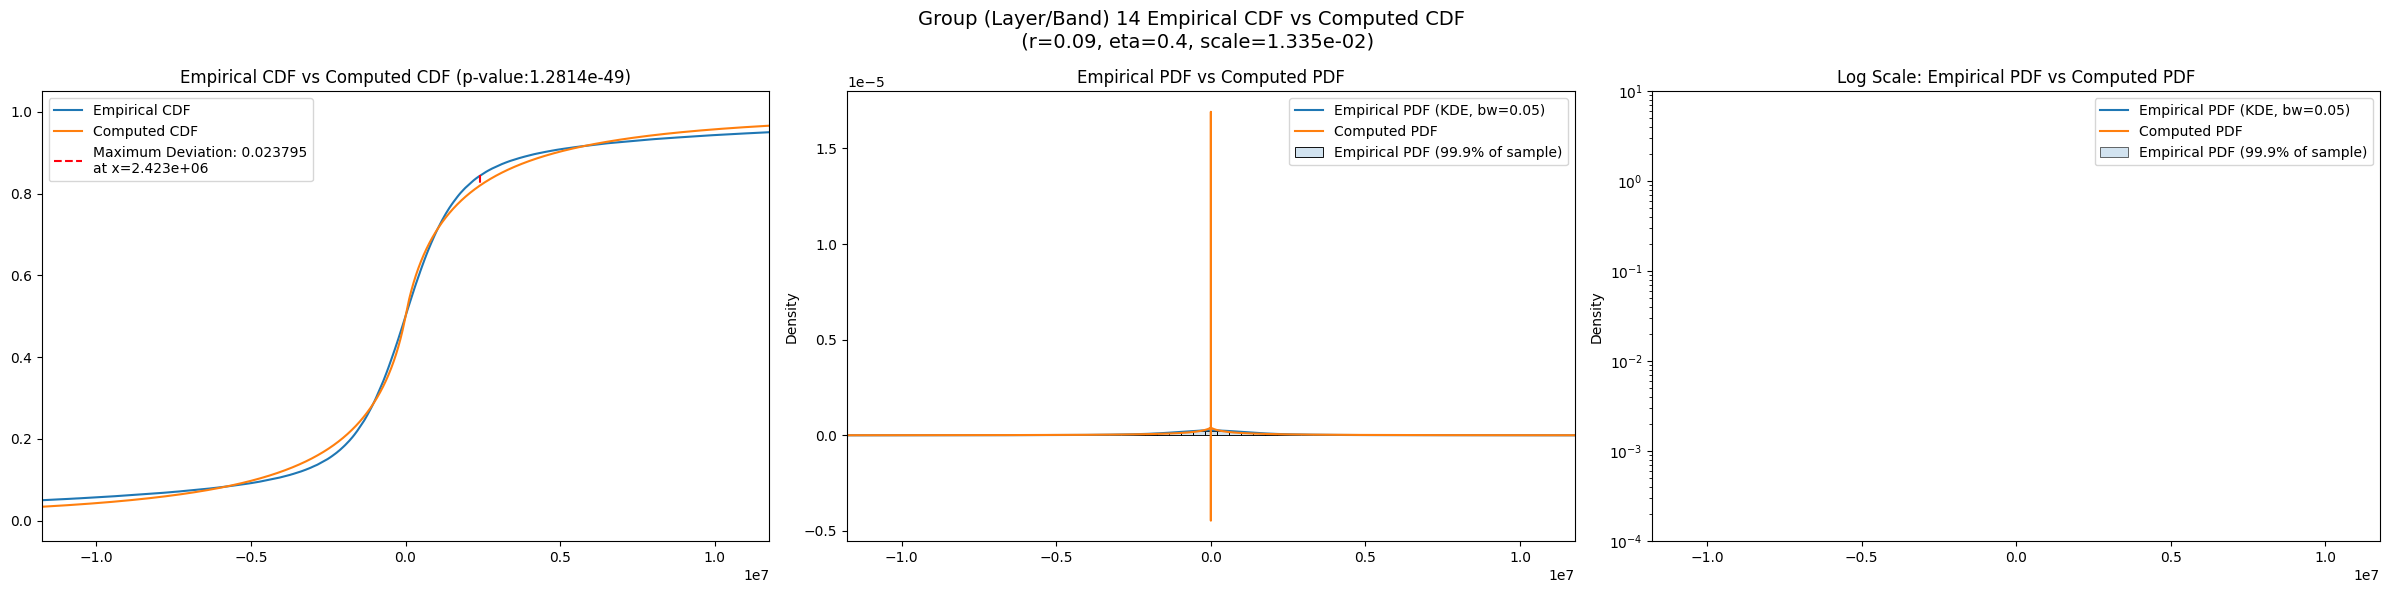

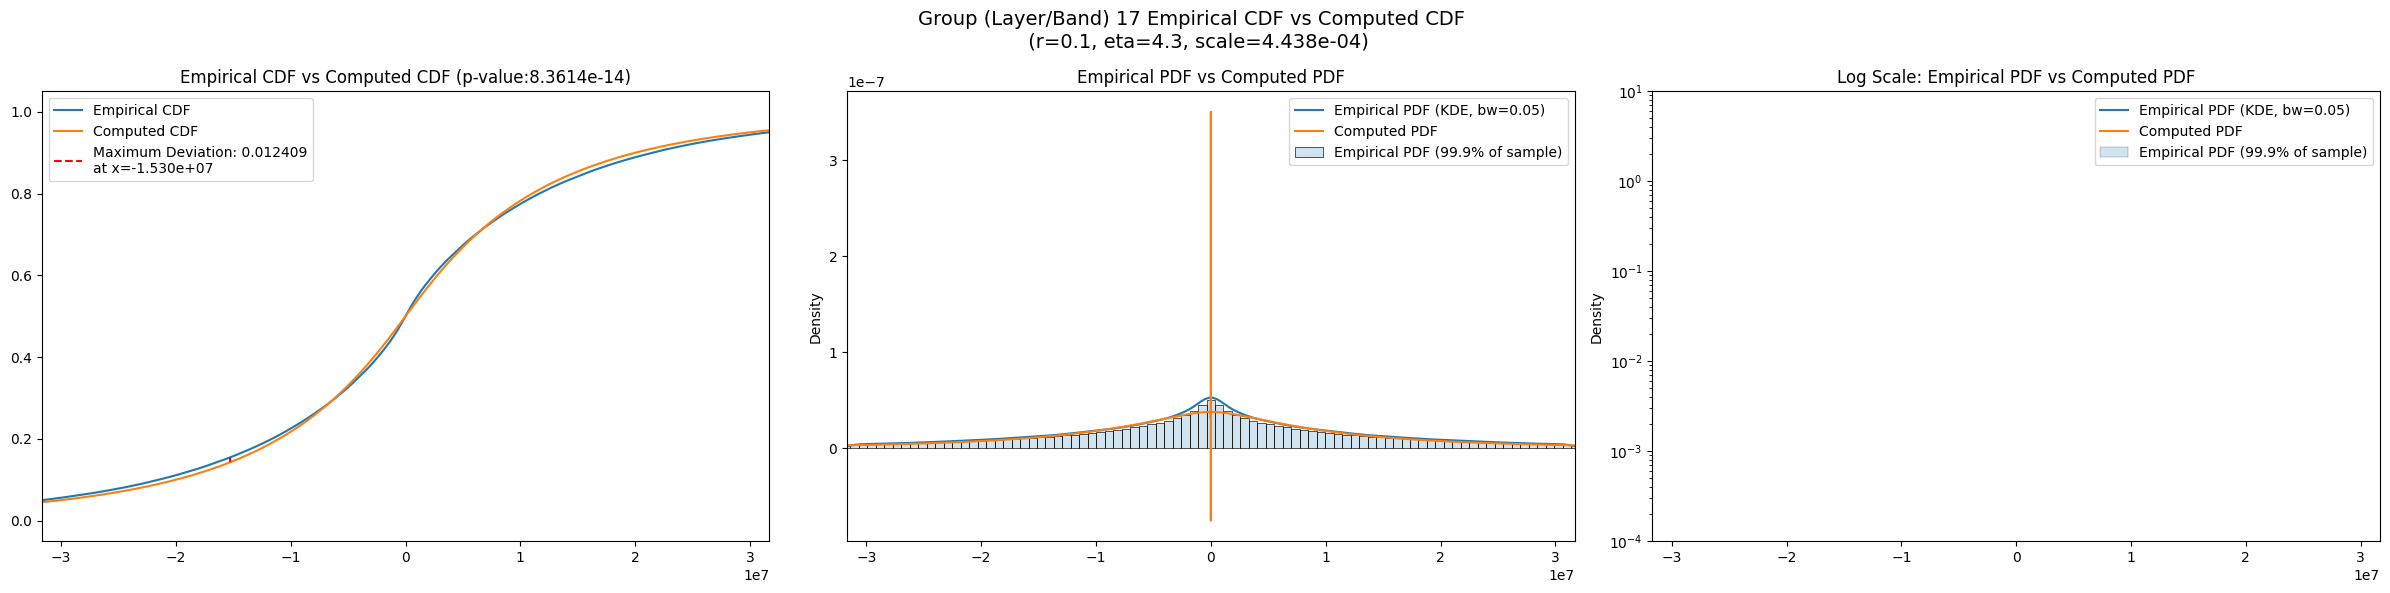

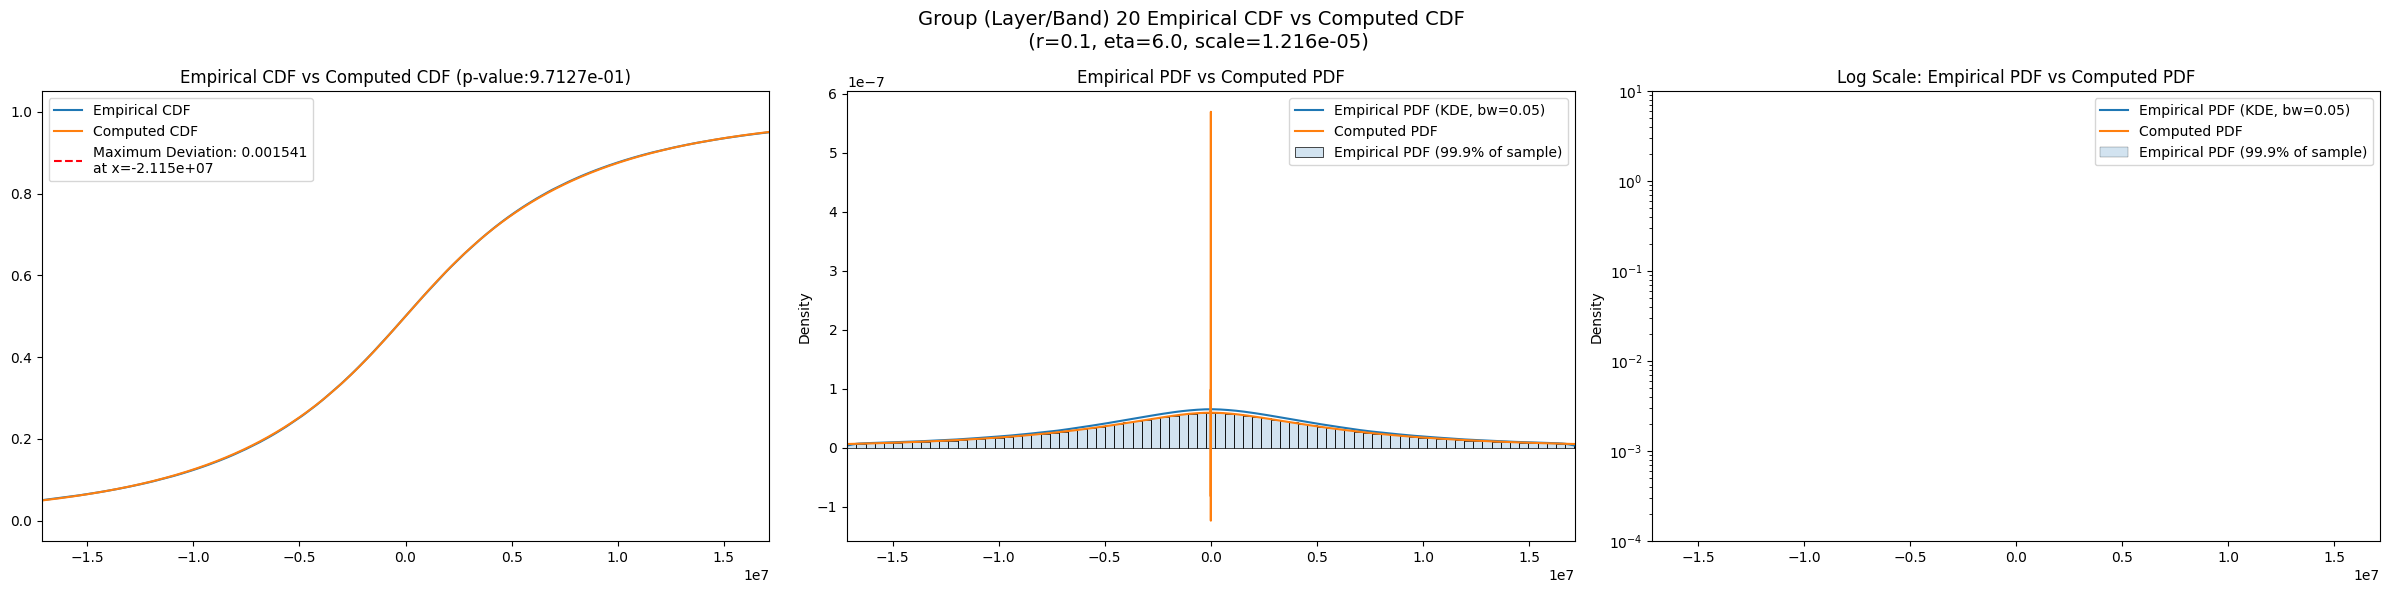

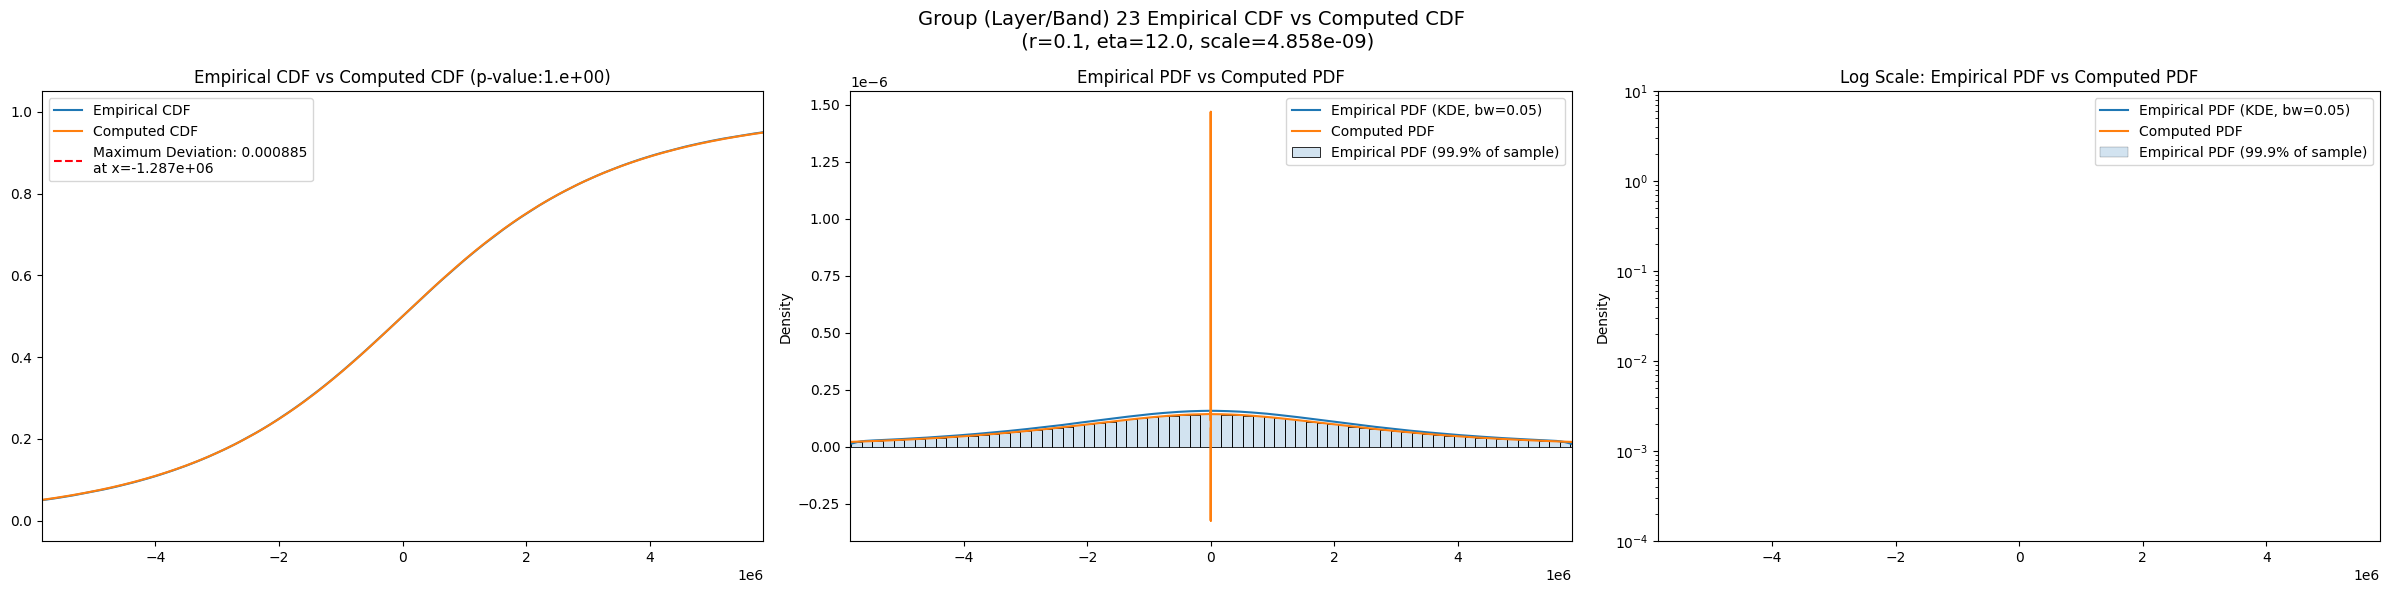

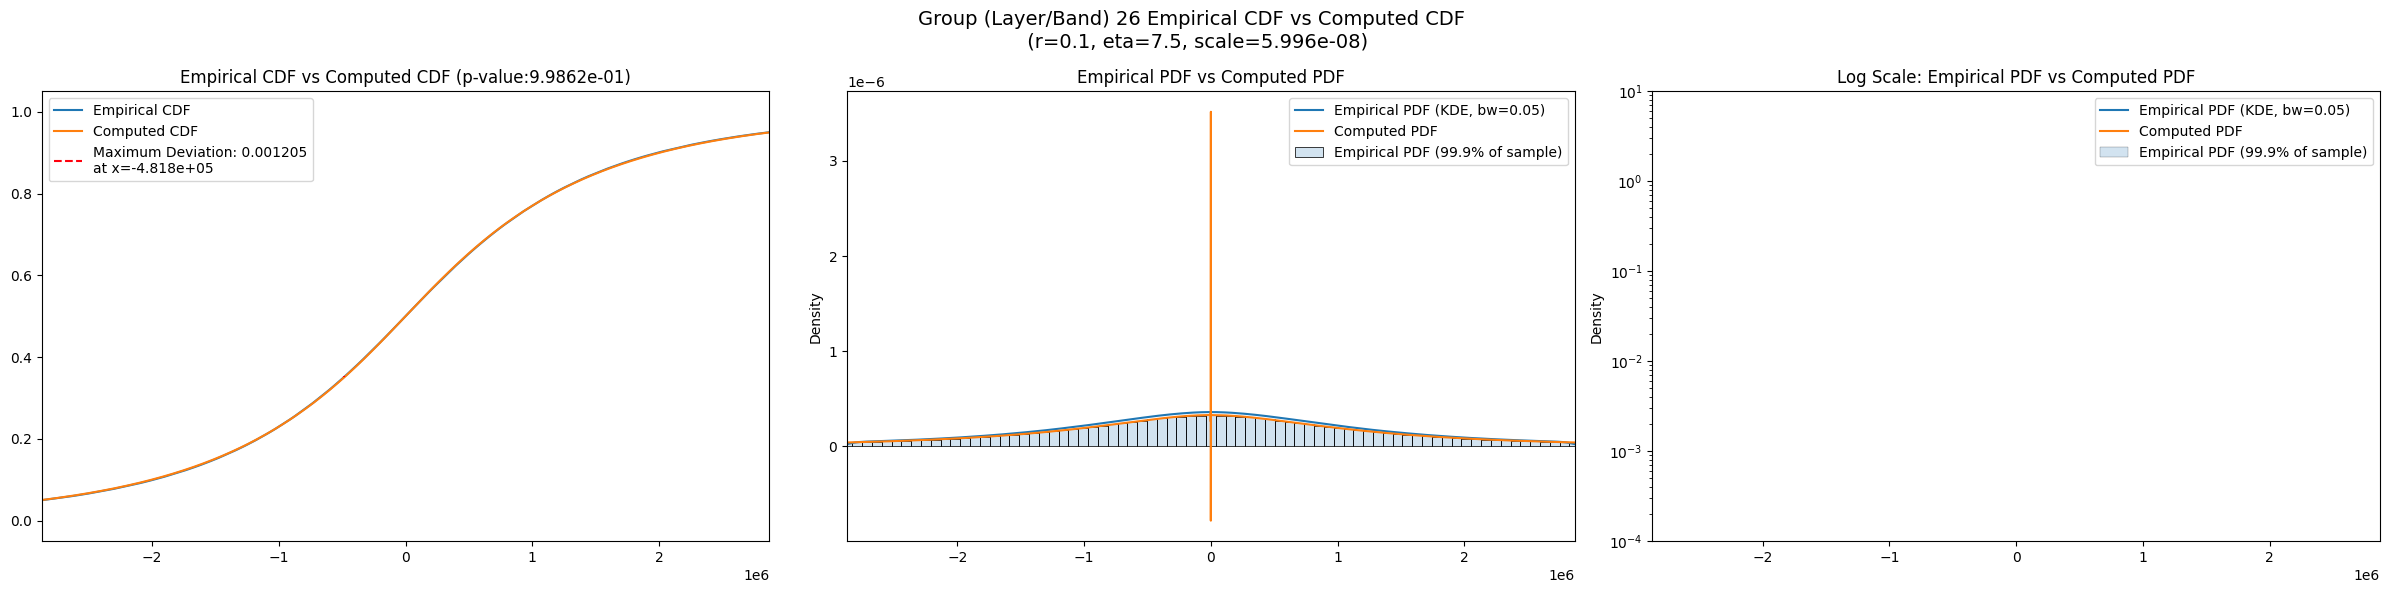

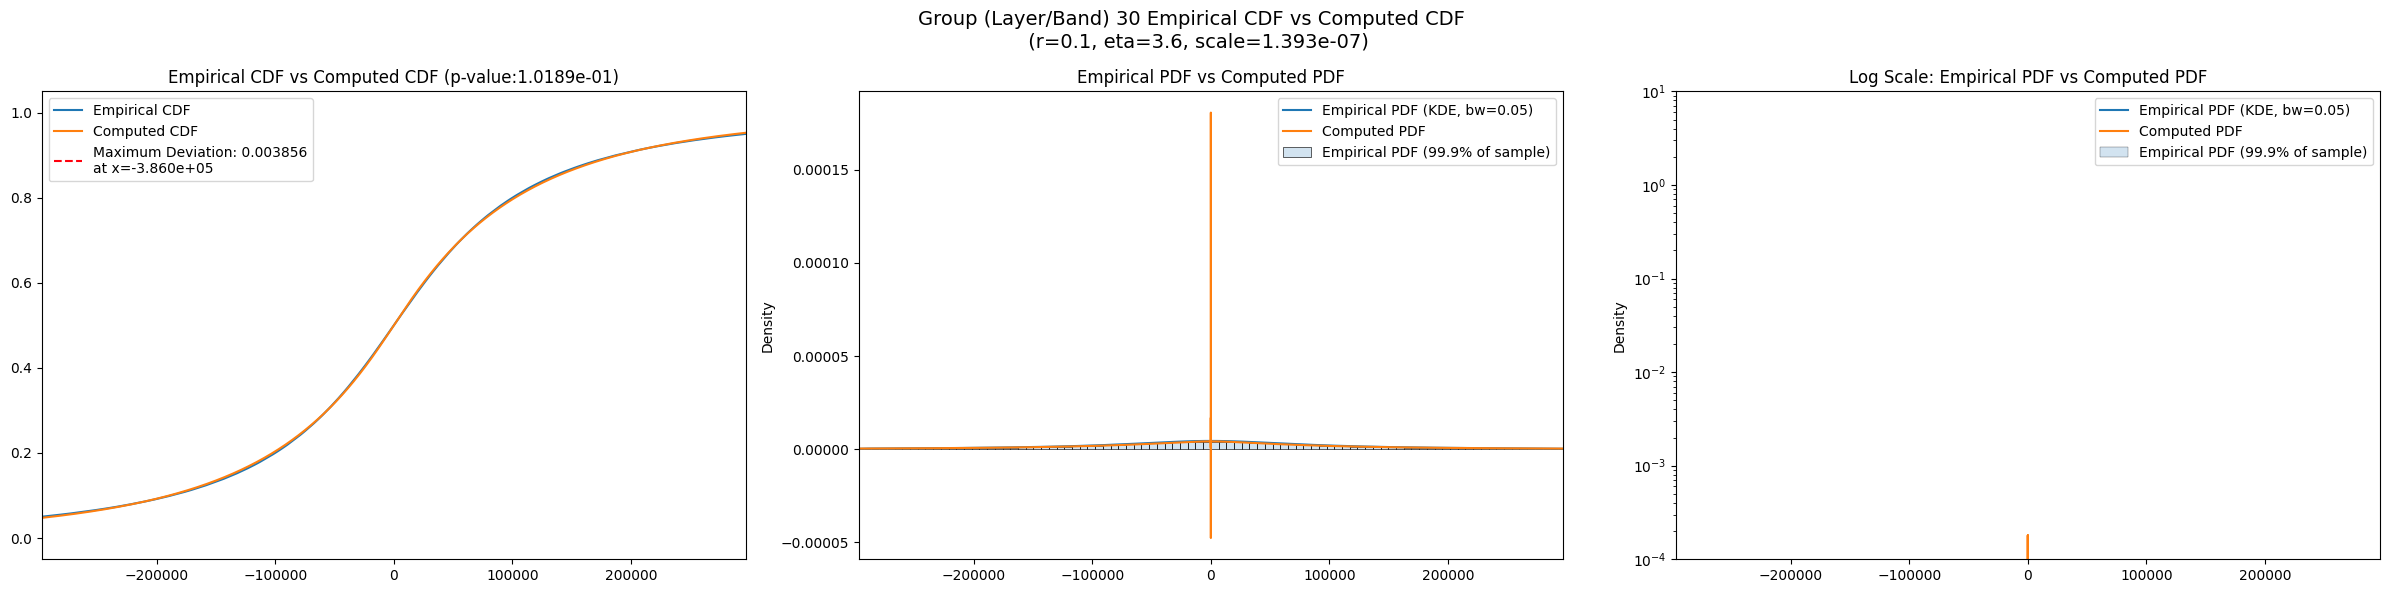

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.613543e+14  3.207987e+14  4.061076e+14   9.142671    6.224052   
5     7.557797e+14  6.677158e+14  8.492265e+14  19.873396   16.942110   
8     1.808529e+14  1.576540e+14  2.063592e+14  25.475584   19.418336   
11    1.057992e+13  9.763951e+12  1.160880e+13   9.404128    3.364547   
14    1.595975e+14  1.321700e+14  1.918671e+14  50.641156   31.101517   
17    3.993602e+14  3.720889e+14  4.289985e+14   5.592850    3.742511   
20    1.263410e+14  1.167919e+14  1.372403e+14   7.696341    4.559319   
23    1.395855e+13  1.306407e+13  1.500763e+13   5.143167    2.566483   
26    3.500124e+12  3.256700e+12  3.775107e+12   6.279109    3.885506   
30    4.321000e+10  3.903768e+10  4.820444e+10  14.699235    8.259990   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      11.805546         2688.0             0.008433        0.1         14.0   
5      22.943187         8064.0             0.015471        0.1          3.3   
8      32.402627        22848.0             0.011988        0.1          5.2   
11     22.641050        63168.0             0.002577        0.2         10.0   
14     83.565282       174720.0             0.025457        0.1          0.1   
17      9.274131       485184.0             0.012409        0.1          4.3   
20     17.831333      1346688.0             0.001541        0.1          6.0   
23     14.589871      3740352.0             0.000885        0.1         12.0   
26     13.782796     10379712.0             0.001205        0.1          7.5   
30     36.812461      7803264.0             0.003857        0.1          3.6   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       1000000.0              0.424958                   0.0   
5     ...       1000000.0              0.403971                   0.0   
8     ...       1000000.0              0.349986                   0.0   
11    ...       1000000.0              0.221550                   0.0   
14    ...       1000000.0              0.161619                   0.0   
17    ...       1000000.0              0.393576                   0.0   
20    ...       1000000.0              0.364101                   0.0   
23    ...       1000000.0              0.236483                   0.0   
26    ...       1000000.0              0.083924                   0.0   
30    ...        133993.0              0.037467                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         1000000.0             0.390327                  0.0  1000000.0   
5         1000000.0             0.365720                  0.0  1000000.0   
8         1000000.0             0.305285                  0.0  1000000.0   
11        1000000.0             0.177444                  0.0  1000000.0   
14        1000000.0             0.115001                  0.0  1000000.0   
17        1000000.0             0.357206                  0.0  1000000.0   
20        1000000.0             0.321082                  0.0  1000000.0   
23        1000000.0             0.190922                  0.0  1000000.0   
26        1000000.0             0.047248                  0.0  1000000.0   
30         117223.0             0.012699                  0.0    95157.2   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.366760            0.0          9.901727e-01  
5          0.342064            0.0          6.265951e-02  
8          0.281259            0.0          2.788733e-03  
11         0.152570            0.0          7.946717e-01  
14         0.090607          

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.008433                 0.026132          0.008433   
5                0.015471                 0.015103          0.014633   
8                0.011988                 0.008977          0.011988   
11               0.002577                 0.005401          0.002577   
14               0.025457                 0.003248          0.023795   
17               0.012409                 0.001949          0.012409   
20               0.001541                 0.001170          0.001541   
23               0.000885                 0.000702          0.000885   
26               0.001205                 0.000422          0.001205   
30               0.003857                 0.000486          0.003857   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.424958             0.390327       0.366760  
5                 0.403971             0.365720       0.342064  
8                 0.349986             0.305285       0.281259  
11                0.221550             0.177444       0.152570  
14                0.161619             0.115001       0.090607  
17                0.393576             0.357206       0.333854  
20                0.364101             0.321082       0.297120  
23                0.236483             0.190922       0.166254  
26                0.083924             0.047248       0.018643  
30                0.037467             0.012699       0.007352

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           2.688531e+14          0.008433    0.10      14.0  2.527043e-08   
5           3.883931e+14          0.014633    0.09       3.6  5.034482e-06   
8           8.788485e+13          0.011988    0.10       5.2  2.537248e-05   
11          9.318537e+12          0.002577    0.20      10.0  1.251344e+04   
14          6.945480e+13          0.023795    0.09       0.4  1.334717e-02   
17          3.993602e+14          0.012409    0.10       4.3  4.437715e-04   
20          1.218070e+14          0.001541    0.10       6.0  1.215735e-05   
23          1.352924e+13          0.000885    0.10      12.0  4.857940e-09   
26          3.389741e+12          0.001205    0.10       7.5  5.995924e-08   
30          3.810075e+10          0.003857    0.10       3.6  1.392623e-07   

      best_exclude_cutoff  
band                       
2                    25.0  
5                   125.0  
8                   350.0  
11                  150.0  
14                  600.0  
17                    0.0  
20                   25.0  
23                   25.0  
26                   25.0  
30                  100.0